# Include S6, S7, H1, H2, and OBJ into the GP model

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/GaussianProcess/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf

failed to import parallelstuff


### Creat the machine interface

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
ndim = 4 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[1098.2, 5, 390000, -654100, -3.7505e6]]

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
# mi_module = importlib.import_module('multinormal')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
# assuming an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background 
# noise with std dev = 0.1

Using TensorFlow backend.


Model loaded


In [4]:
print(mi.x)
#check the reading objective is working
temp = mi.getState()
print(temp[1][0][0])

[[ 1.0982e+03  5.0000e+00  3.9000e+05 -6.5410e+05 -3.7505e+06]]


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[8.994672]]
-8.994672


In [ ]:
#check noise std
y = [mi.getState()[1][0] for x in range(5)]
np.std(y)

### Create the gp

In [13]:
# parameter determined by GPy from 1D linescans, gp_amp is the average of the four
gp_ls = np.array(np.ones(ndim)) * [1.580, 11.44, 1.276, 2.411, 2.0]
gp_amp = 909
gp_noise = 5.91e-5  # default = 0.001

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

gp = OGP(ndim, hyps,prmean=0)

In [14]:
gp_ls

array([ 1.58 , 11.44 ,  1.276,  2.411])

### Create the BO

In [15]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([0.002, 0.4])
opt.ucb_params = np.array([2, None])

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f068c717e48>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
[[8.994672]]
x_init [[ 1.0982e+03  5.0000e+00  3.9000e+05 -6.5410e+05]]
y_init [[-8.994672]]
Using prior mean function of  0
Using prior mean parameters of  None


**Running BO**

*run the gp search for some number of steps*

In [16]:
Obj_state_s=[]
Obj_state_s.append(mi.getState()[1][0])

[[8.994672]]


[[8.994672]]
iteration = 0


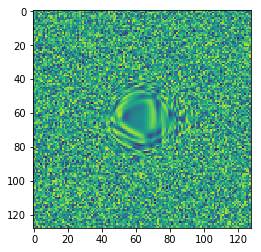

[[8.693866]]
New State: [[ 1.05243308e+03 -1.20621590e+01  3.94554353e+05 -6.30000000e+05]], [[-8.693866]]
(array([ 1.05243308e+03, -1.20621590e+01,  3.94554353e+05, -6.30000000e+05]), array([[-8.693866]], dtype=float32))
iteration = 1


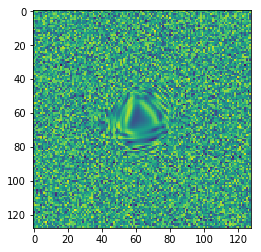

[[13.096289]]
New State: [[ 1.63579995e+03 -2.11016713e+01  3.95367968e+05 -6.30000000e+05]], [[-13.096289]]
(array([ 1.05243308e+03, -1.20621590e+01,  3.94554353e+05, -6.30000000e+05]), array([[-8.693866]], dtype=float32))
iteration = 2


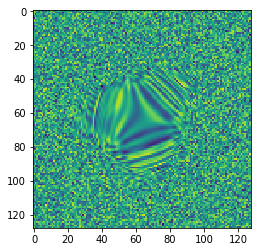

[[4.5633545]]
New State: [[ 7.60527165e+02  1.17518787e+01  3.94461241e+05 -6.30000000e+05]], [[-4.5633545]]
(array([ 7.60527165e+02,  1.17518787e+01,  3.94461241e+05, -6.30000000e+05]), array([[-4.5633545]], dtype=float32))
iteration = 3


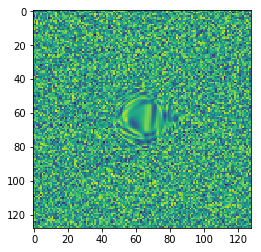

[[2.5593386]]
New State: [[ 1.67787780e+03 -1.74400715e+01  3.80510063e+05 -6.30000000e+05]], [[-2.5593386]]
(array([ 1.67787780e+03, -1.74400715e+01,  3.80510063e+05, -6.30000000e+05]), array([[-2.5593386]], dtype=float32))
iteration = 4


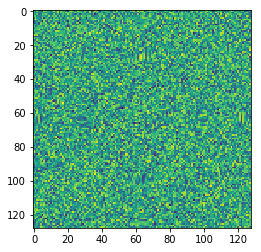

[[4.8930225]]
New State: [[ 7.63294333e+02  1.87779632e+01  3.94446649e+05 -6.30000000e+05]], [[-4.8930225]]
(array([ 1.67787780e+03, -1.74400715e+01,  3.80510063e+05, -6.30000000e+05]), array([[-2.5593386]], dtype=float32))
iteration = 5


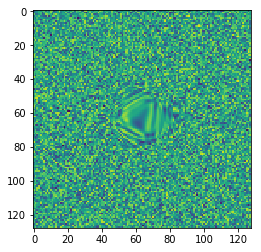

[[2.6391277]]
New State: [[ 1.36709308e+03  1.50159377e+01  3.86877047e+05 -6.30000000e+05]], [[-2.6391277]]
(array([ 1.67787780e+03, -1.74400715e+01,  3.80510063e+05, -6.30000000e+05]), array([[-2.5593386]], dtype=float32))
iteration = 6


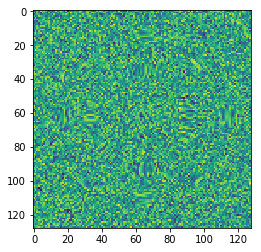

[[2.5696478]]
New State: [[ 1.44312530e+03  1.58119257e+01  3.85084779e+05 -6.30000000e+05]], [[-2.5696478]]
(array([ 1.67787780e+03, -1.74400715e+01,  3.80510063e+05, -6.30000000e+05]), array([[-2.5593386]], dtype=float32))
iteration = 7


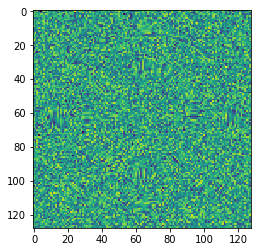

[[3.341404]]
New State: [[ 1.13449177e+03  7.20987804e+00  3.90114608e+05 -6.30000000e+05]], [[-3.341404]]
(array([ 1.67787780e+03, -1.74400715e+01,  3.80510063e+05, -6.30000000e+05]), array([[-2.5593386]], dtype=float32))
iteration = 8


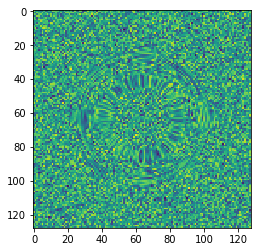

[[2.0932302]]
New State: [[ 5.43716874e+02  5.44591245e+00  3.81715361e+05 -6.30000000e+05]], [[-2.0932302]]
(array([ 5.43716874e+02,  5.44591245e+00,  3.81715361e+05, -6.30000000e+05]), array([[-2.0932302]], dtype=float32))
iteration = 9


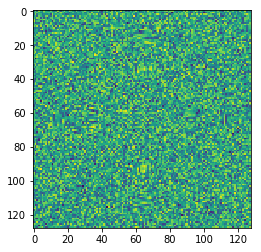

[[2.4536552]]
New State: [[ 1.10004130e+03  2.50815539e+01  3.96396901e+05 -6.30000000e+05]], [[-2.4536552]]
(array([ 5.43716874e+02,  5.44591245e+00,  3.81715361e+05, -6.30000000e+05]), array([[-2.0932302]], dtype=float32))
iteration = 10


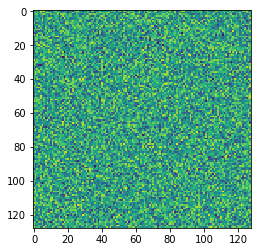

[[1.8700485]]
New State: [[ 1.31335067e+03 -2.53641736e+01  3.81116477e+05 -6.30000000e+05]], [[-1.8700485]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 11


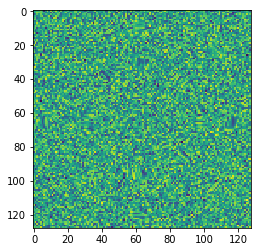

[[2.976512]]
New State: [[ 1.99591765e+03  1.04872242e+01  3.80794085e+05 -6.30000000e+05]], [[-2.976512]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 12


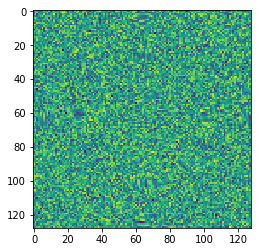

[[2.084669]]
New State: [[ 1.80572764e+03  1.51014074e+01  3.97507530e+05 -6.30000000e+05]], [[-2.084669]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 13


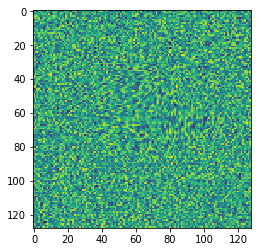

[[2.5093699]]
New State: [[ 1.60925393e+03 -8.18054183e+00  3.86375458e+05 -6.30000000e+05]], [[-2.5093699]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 14


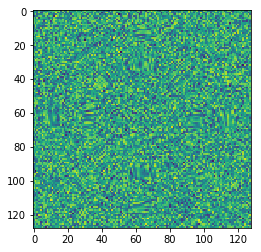

[[2.428378]]
New State: [[ 8.84718664e+02  1.94593315e+01  3.82224499e+05 -6.30000000e+05]], [[-2.428378]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 15


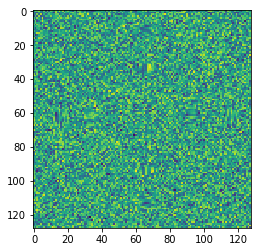

[[3.232726]]
New State: [[ 1.27023937e+03  3.47507232e+00  3.98946551e+05 -6.30000000e+05]], [[-3.232726]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 16


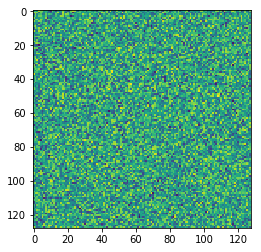

[[2.6636276]]
New State: [[ 7.62048783e+02 -2.27092510e+01  3.89901843e+05 -6.30000000e+05]], [[-2.6636276]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 17


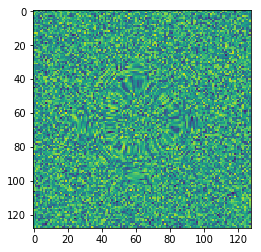

[[2.4218578]]
New State: [[ 1.48552354e+03  1.37082907e+01  3.85442874e+05 -6.30000000e+05]], [[-2.4218578]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 18


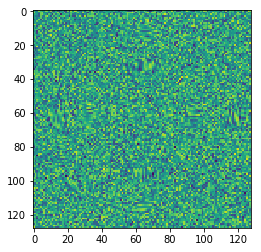

[[2.6823997]]
New State: [[ 1.57282918e+03  2.53951706e+01  3.87621188e+05 -6.30000000e+05]], [[-2.6823997]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 19


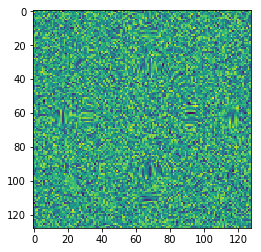

[[2.0020332]]
New State: [[ 1.92527890e+03  9.63221617e+00  3.97855540e+05 -6.30000000e+05]], [[-2.0020332]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 20


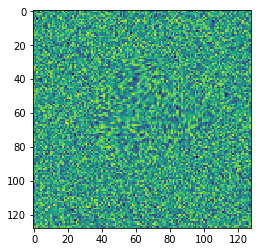

[[4.0997458]]
New State: [[ 1.43676521e+03 -1.95167836e+01  3.91417569e+05 -6.30000000e+05]], [[-4.0997458]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 21


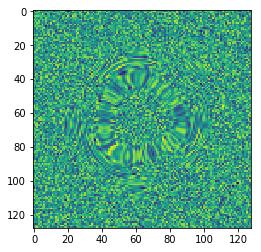

[[2.356326]]
New State: [[ 1.04018467e+03  1.34250082e+01  3.98952808e+05 -6.30000000e+05]], [[-2.356326]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 22


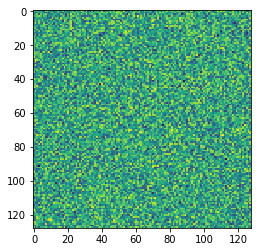

[[11.833603]]
New State: [[ 1.72011037e+03 -1.18988652e+01  3.93583300e+05 -6.30000000e+05]], [[-11.833603]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 23


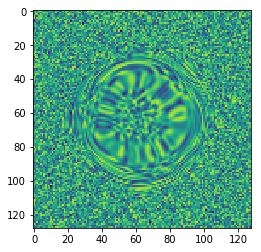

[[2.617877]]
New State: [[ 5.32833626e+02  1.31960827e+01  3.87586374e+05 -6.30000000e+05]], [[-2.617877]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 24


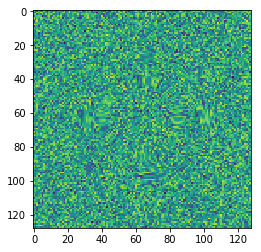

[[2.315895]]
New State: [[ 1.24617509e+03 -2.15102990e+01  3.84017428e+05 -6.30000000e+05]], [[-2.315895]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 25


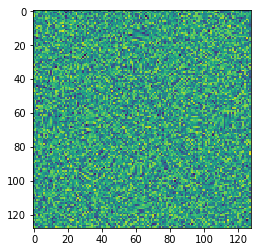

[[2.7696753]]
New State: [[ 1.31044613e+03 -1.09516076e+00  3.81832994e+05 -6.30000000e+05]], [[-2.7696753]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 26


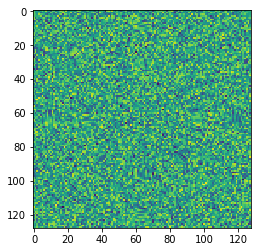

[[5.715578]]
New State: [[ 1.67598217e+03  4.09826709e+00  3.95999306e+05 -6.30000000e+05]], [[-5.715578]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 27


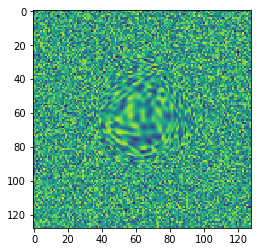

[[2.9690819]]
New State: [[ 1.53654169e+03  2.26060412e+01  3.81111206e+05 -6.30000000e+05]], [[-2.9690819]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 28


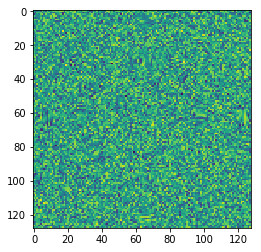

[[2.0325975]]
New State: [[ 9.66158541e+02 -3.42689038e+00  3.80625234e+05 -6.30000000e+05]], [[-2.0325975]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 29


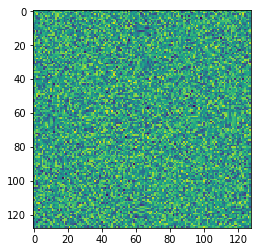

[[2.0818672]]
New State: [[ 6.57471354e+02  3.21368494e+01  3.84318258e+05 -6.30000000e+05]], [[-2.0818672]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 30


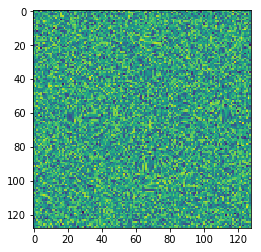

[[3.1992226]]
New State: [[ 1.56339248e+03  3.07568260e+01  3.98813267e+05 -6.30000000e+05]], [[-3.1992226]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 31


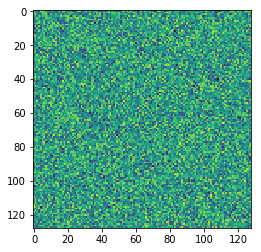

[[2.5594807]]
New State: [[ 7.99794510e+02  1.28805914e+01  3.96512760e+05 -6.30000000e+05]], [[-2.5594807]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 32


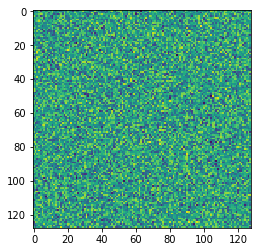

[[2.0466518]]
New State: [[ 1.20962291e+03 -5.93942175e+00  3.98320718e+05 -6.30000000e+05]], [[-2.0466518]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 33


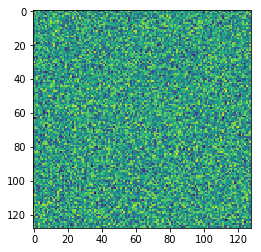

[[2.3511753]]
New State: [[ 5.42628266e+02 -8.06252585e+00  3.80894325e+05 -6.30000000e+05]], [[-2.3511753]]
(array([ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05, -6.30000000e+05]), array([[-1.8700485]], dtype=float32))
iteration = 34


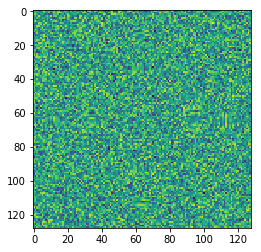

/home/chenyu/Desktop/GaussianProcess/GPTrelated/uscope_calc.py:124: UserWarning: loadtxt: Empty input file: "outscope.txt"
  screen =  np.loadtxt(ASCIIFILE, skiprows=5)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [17]:
# Test over single starting point
Niter = 100
Status_array = np.zeros([Niter + 1, 6]) # save the 
Status_array[0,0] = opt.current_x[0][0]
Status_array[0,1] = opt.current_x[0][1]
Status_array[0,2] = opt.current_x[0][2]
Status_array[0,3] = opt.current_x[0][3]
Status_array[0,4] = Status_array[0,5] = mi.getState()[1][0]
for i in range(Niter):
    
    print ('iteration =', i)
#     print ('current position:', mi.x, 'current best seen objective value:', Obj_state_s[-1])
    fig = plt.figure(figsize=(4,4))
    temp = np.load('ronchigram.npy')
    plt.imshow(temp)
    plt.show()
    
    temp = opt.OptIter() # save the new acquisition point and objective value
    Obj_state_s.append(opt.best_seen()[1]) # save current best value
    Status_array[i+1, 5] = opt.best_seen()[1][0][0]  # best seen objective so far
    Status_array[i+1, 4] = temp[1][0][0]  # objective at new point
    Status_array[i+1, 0] = temp[0][0][0]  # coordinate of new point
    Status_array[i+1, 1] = temp[0][0][1]
    Status_array[i+1, 2] = temp[0][0][2]
    Status_array[i+1, 3] = temp[0][0][3]
    
    print(opt.best_seen())

Model loaded
[[ 1.31335067e+03 -2.53641736e+01  3.81116477e+05 -6.30000000e+05]]
[[1.8700485]]
(array([[ 1.31335067e+03, -2.53641736e+01,  3.81116477e+05,
        -6.30000000e+05]]), array([[-1.8700485]], dtype=float32))


(-0.5, 127.5, 127.5, -0.5)

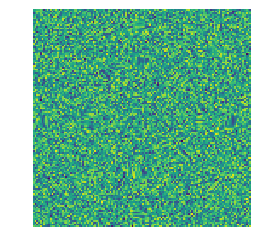

In [18]:
start_point = [opt.best_seen()[0]]
# start_point = [[899,0.1]]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point)
print(mi.x)
print(mi.getState())
temp = np.load('ronchigram.npy')
plt.imshow(temp)
plt.axis('off')

In [33]:
np.save('Start_200-34_UCB_2-0_100iter.npy',Status_array)

(0, 100)

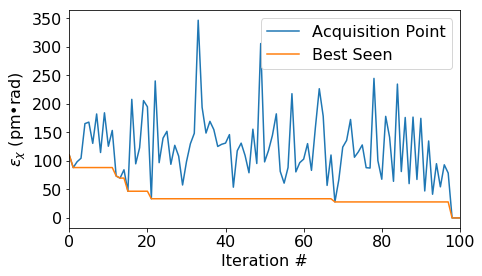

In [23]:
fig = plt.figure(figsize = (7,4))

plt.subplot(111)
plt.plot(-Status_array[0:-1,4],'-',c='C0', label = 'Acquisition Point')
plt.plot(-Status_array[0:-1,5],c='C1', label = 'Best Seen')
# plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.legend(fontsize=16, bbox_to_anchor=[0.9, 0.1],loc = 'lower right')
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('$\epsilon_\chi$ (pm\u2022rad)', fontsize=16)
plt.xlim([0,100])

(-0.5, 200.5, 200.5, -0.5)

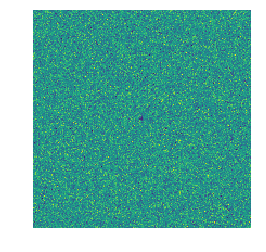

In [41]:
temp = np.load('ronchigram.npy')
plt.imshow(temp)
plt.axis('off')

/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


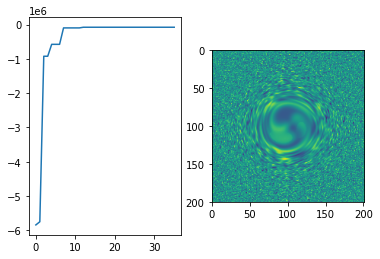

In [101]:
# print(opt.best_seen())
# print(np.asarray(Obj_state_s))
plt.subplot(121)
plt.plot(np.asarray(Obj_state_s))
plt.subplot(122)
temp = np.load('/home/cz489/STEMalign_BO/ronchigram.npy')
plt.imshow(temp)
np.save('Start_point_5.9_4.95_mag3e5_noise10_asymmetric.npy', np.asarray(Obj_state_s))

Text(0, 0.5, 'Emittance^2')

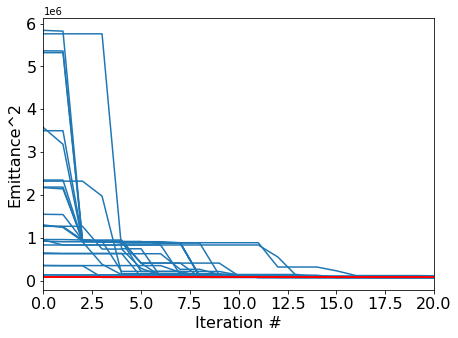

In [87]:
fig = plt.figure(figsize = (7,5))
for i in range(Obj_list.shape[0]):
    plt.plot(-Obj_list[i,2::], ls = '-',c='C0')
plt.xlim([0,20])
grid_search = np.load('2Dscan_-10-10_H1_H2.npy')
plt.axhline(y=-np.amax(grid_search), c='red', linewidth = 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('Emittance^2', fontsize = 16)

## Test different random starting points

In [48]:
# Test over multiple different starting point
Niter = 150
Ntest_point = 30  # total number of test points
H1_range = [0, 1500]
H2_range = [-35, 35]
Obj_list = np.zeros((Ntest_point, Niter + 3))
# Obj_list = np.load('DiffStarPointTest_newGPT_60iter_30pts.npy')

for itest in range(Ntest_point):
    rs = np.random.RandomState()
    count = itest
    if Obj_list[count,Niter+2] != 0:
        break

    start_point = [[H1_range[0] + rs.rand()*(H1_range[1] - H1_range[0]), 
                    H2_range[0] + rs.rand()*(H2_range[1] - H2_range[0])]]
    # For each starting point, create a new mi with the new start_point par, then a new opt to connect to the new mi
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    gp_ls = np.array(np.ones(ndim)) * 1.30 * [160, 5]
    gp_amp = 100 # default = 1
#     gp_amp = 1.76e6
    gp_noise = 1.80e-4

    gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
    hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

    gp = OGP(ndim, hyps,prmean=0)

    opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
    opt.ucb_params = np.array([2, None])
    Obj_list[count,0] = start_point[0][0]  # starting points
    Obj_list[count,1] = start_point[0][1]
    Obj_list[count,2] = mi.getState()[1][0]  # initial state

    for i in range(Niter):
        opt.OptIter()
        Obj_list[count,i+3] = opt.best_seen()[1]  # save the best objective in each iteration
#             Obj_state_s.append(opt.best_seen()[1])
    print(str(start_point[0][0]) + ', ' + str(start_point[0][1]) + ', ' + str(itest)+ ' Finished.')
    np.save('DiffStarPointTest_newGPT_150iter_30pts.npy',Obj_list)

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f6bd9a2e908>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[487.79595345  17.82992937]]
y_init [[-6.83303185]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, minimize, x_start = [956.5968813170327, 28.55647238279908]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 2, 2, None)
Minimizing finished, min point = [956.59688132  28.55647238]
New State: [[956.59688132  28.55647238]], [[-10.28292861]]
single-processing, minimize, x_start = [1387.3847515284424, -28.646597785375523]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 3, 2, None)
Minimizing finished, min point = [1387.38475153  -28.64659779]
New State: [[1387.38475153  -28.64659779]], [[-11.18899061]]
single-processing, minimize, x_start = [1093.9622229609395, -8.081842054227508]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 4, 2,

New State: [[1444.74095391  -20.21513927]], [[-8.88251195]]
single-processing, minimize, x_start = [600.9055483316827, 27.118900532941424]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 33, 2, None)
Minimizing finished, min point = [600.89958941  20.37051996]
New State: [[600.89958941  20.37051996]], [[-7.54964927]]
single-processing, minimize, x_start = [1328.4394702025124, 0.9313286005968848]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 34, 2, None)
Minimizing finished, min point = [1281.35552082   -4.82392688]
New State: [[1281.35552082   -4.82392688]], [[-3.80283577]]
single-processing, minimize, x_start = [1436.256948024962, 19.846770357094393]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 35, 2, None)
Minimizing finished, min point = [1500.           24.23385273]
New State: [[1500.           24.23385273]], [[-10.66774465]]
single-processing, minimize, x_start = [1309.4566869839748, 5.989367453475261]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 36, 2,

New State: [[1238.61308413  -21.20848371]], [[-8.12829106]]
single-processing, minimize, x_start = [1150.5299126019452, 1.445091874195036]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 65, 2, None)
Minimizing finished, min point = [1150.5187052    -2.26495553]
New State: [[1150.5187052    -2.26495553]], [[-2.23615642]]
single-processing, minimize, x_start = [669.9881517361684, 24.598003622344542]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 66, 2, None)
Minimizing finished, min point = [496.12033119   7.93621565]
New State: [[496.12033119   7.93621565]], [[-3.7055884]]
single-processing, minimize, x_start = [351.0815798513266, -18.101222650196554]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 67, 2, None)
Minimizing finished, min point = [245.74671203 -24.22405875]
New State: [[245.74671203 -24.22405875]], [[-9.2652496]]
single-processing, minimize, x_start = [1432.2382643282251, 7.714102510768832]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 68, 2, None)


New State: [[  0.         -26.45078237]], [[-10.09313812]]
single-processing, minimize, x_start = [800.758170458855, 6.745426916696282]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 96, 2, None)
Minimizing finished, min point = [7.99792790e+02 1.76884174e-02]
New State: [[7.99792790e+02 1.76884174e-02]], [[-0.74601307]]
single-processing, minimize, x_start = [1431.4046142965194, 34.93102320264346]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 97, 2, None)
Minimizing finished, min point = [1321.1353182   35.       ]
New State: [[1321.1353182   35.       ]], [[-13.24265431]]
single-processing, minimize, x_start = [974.2297825598814, -5.110931831691847]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 98, 2, None)
Minimizing finished, min point = [974.22978256  -5.11093184]
New State: [[974.22978256  -5.11093184]], [[-1.90256523]]
single-processing, minimize, x_start = [11.469339200569696, -15.812509501402516]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 99, 2, N

New State: [[539.88167013   0.55951855]], [[-2.20341058]]
single-processing, minimize, x_start = [1185.0875673927003, -3.3478116997572585]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 127, 2, None)
Minimizing finished, min point = [1185.08756739   -3.3478117 ]
New State: [[1185.08756739   -3.3478117 ]], [[-2.69390696]]
single-processing, minimize, x_start = [976.3705092628674, 23.741258654461603]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 128, 2, None)
Minimizing finished, min point = [1022.43673643   20.8848112 ]
New State: [[1022.43673643   20.8848112 ]], [[-7.58603983]]
single-processing, minimize, x_start = [1249.4467213807952, 12.863619950879873]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 129, 2, None)
Minimizing finished, min point = [ 1.25456800e+03 -5.62677509e-01]
New State: [[ 1.25456800e+03 -5.62677509e-01]], [[-3.14089666]]
single-processing, minimize, x_start = [188.53233919219136, 5.025498463837508]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2ee

/home/chenyu/Desktop/GaussianProcess/modules/bayes_optimization.py:512: RuntimeWarning: invalid value encountered in sqrt
  GPUCB = y_mean + nu * np.sqrt(y_var)


New State: [[739.38353106   1.2221753 ]], [[-1.21214669]]
single-processing, minimize, x_start = [581.8765919991823, -4.23156969441035]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 141, 2, None)
Minimizing finished, min point = [581.876592    -4.23156969]
New State: [[581.876592    -4.23156969]], [[-2.51990699]]
single-processing, minimize, x_start = [368.5424324204417, -21.916474472274665]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 142, 2, None)
Minimizing finished, min point = [353.38943285  -2.03878871]
New State: [[353.38943285  -2.03878871]], [[-2.98402764]]
single-processing, minimize, x_start = [589.9382498602806, 18.65063716810419]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 143, 2, None)
Minimizing finished, min point = [592.45004026   8.94160592]
New State: [[592.45004026   8.94160592]], [[-3.74517977]]
single-processing, minimize, x_start = [307.90923677776607, -30.44951078449717]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2eeb8>, 2, 144, 2, None)
M

New State: [[ 41.56263995 -35.        ]], [[-13.02441999]]
single-processing, minimize, x_start = [1161.0128769864082, -9.388715532080635]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 21, 2, None)
Minimizing finished, min point = [  0.         -17.32615018]
New State: [[  0.         -17.32615018]], [[-7.09553083]]
single-processing, minimize, x_start = [1088.1398408041857, -11.61303140368928]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 22, 2, None)
Minimizing finished, min point = [ 1.00697488e+03 -4.44484744e-01]
New State: [[ 1.00697488e+03 -4.44484744e-01]], [[-0.82404236]]
single-processing, minimize, x_start = [1177.0521843104364, 19.95401134761771]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 23, 2, None)
Minimizing finished, min point = [1060.51791702   35.        ]
New State: [[1060.51791702   35.        ]], [[-12.67204273]]
single-processing, minimize, x_start = [59.714629960824716, -34.764839666960384]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>,

New State: [[810.85950015  35.        ]], [[-12.59206403]]
single-processing, minimize, x_start = [399.06919660393845, 16.750302841891653]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 52, 2, None)
Minimizing finished, min point = [398.86471304  20.57159348]
New State: [[398.86471304  20.57159348]], [[-7.87086498]]
single-processing, minimize, x_start = [257.2216013069935, -14.510368516215951]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 53, 2, None)
Minimizing finished, min point = [ 0.         -6.99584492]
New State: [[ 0.         -6.99584492]], [[-4.23542529]]
single-processing, minimize, x_start = [759.6414735318423, 18.635741760503386]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 54, 2, None)
Minimizing finished, min point = [718.38589751  11.53842391]
New State: [[718.38589751  11.53842391]], [[-4.32448226]]
single-processing, minimize, x_start = [1434.6366250318574, -23.40626603686481]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 55, 2, None)
Minim

New State: [[853.71057256  -7.26304351]], [[-2.63676578]]
single-processing, minimize, x_start = [1194.6880515859941, 27.99325257766023]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 83, 2, None)
Minimizing finished, min point = [1278.75345065   35.        ]
New State: [[1278.75345065   35.        ]], [[-13.10506488]]
single-processing, minimize, x_start = [799.8726056446067, 9.648469927161933]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 84, 2, None)
Minimizing finished, min point = [889.08232207  13.30123434]
New State: [[889.08232207  13.30123434]], [[-4.78539253]]
single-processing, minimize, x_start = [1096.264682984618, -17.33339402586094]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 85, 2, None)
Minimizing finished, min point = [1500.           25.95732007]
New State: [[1500.           25.95732007]], [[-11.18807969]]
single-processing, minimize, x_start = [9.238695870298852, 7.824003741409555]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 86, 2, Non

New State: [[167.37239127 -23.84191347]], [[-9.18095786]]
single-processing, minimize, x_start = [408.02035165882256, 14.959862480097968]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 114, 2, None)
Minimizing finished, min point = [409.97499494  -2.83477477]
New State: [[409.97499494  -2.83477477]], [[-2.89942119]]
single-processing, minimize, x_start = [802.8818185419402, 1.426586248362753]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 115, 2, None)
Minimizing finished, min point = [ 8.00100900e+02 -4.00633464e-02]
New State: [[ 8.00100900e+02 -4.00633464e-02]], [[-0.74420157]]
single-processing, minimize, x_start = [647.3449193693325, -32.38418880898843]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 116, 2, None)
Minimizing finished, min point = [801.60893915 -29.60758092]
New State: [[801.60893915 -29.60758092]], [[-10.66850726]]
single-processing, minimize, x_start = [167.57049669444456, 32.652965007513174]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 1

New State: [[1.28595177e+03 3.93644396e-01]], [[-3.47548419]]
single-processing, minimize, x_start = [913.2580940626631, 20.59787883067078]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 145, 2, None)
Minimizing finished, min point = [913.85650096  22.32155509]
New State: [[913.85650096  22.32155509]], [[-8.02891313]]
single-processing, minimize, x_start = [614.4240740469637, 12.746257090220361]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 146, 2, None)
Minimizing finished, min point = [614.42407406  12.7462571 ]
New State: [[614.42407406  12.7462571 ]], [[-4.922123]]
single-processing, minimize, x_start = [83.79574781061349, -20.484364046369546]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 147, 2, None)
Minimizing finished, min point = [84.22833522 -8.26305544]
New State: [[84.22833522 -8.26305544]], [[-4.50046196]]
single-processing, minimize, x_start = [32.15915015088028, 6.964277219734285]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 148, 2, None)
Mini

New State: [[826.74274504  35.        ]], [[-12.58828531]]
single-processing, minimize, x_start = [1379.3415184808382, 28.52521514558763]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 25, 2, None)
Minimizing finished, min point = [1167.33822523   35.        ]
New State: [[1167.33822523   35.        ]], [[-12.83072895]]
single-processing, minimize, x_start = [1078.0377403246275, 33.04933937168036]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 26, 2, None)
Minimizing finished, min point = [1105.44285522  -35.        ]
New State: [[1105.44285522  -35.        ]], [[-12.66042063]]
single-processing, minimize, x_start = [306.64346149117466, -18.048824064951095]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 27, 2, None)
Minimizing finished, min point = [532.8697922 -21.3225654]
New State: [[532.8697922 -21.3225654]], [[-7.99069262]]
single-processing, minimize, x_start = [279.3284164614706, 5.207089629522045]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 28, 2, Non

New State: [[  0.         -25.04851389]], [[-9.62060655]]
single-processing, minimize, x_start = [104.61343717177274, 5.895980580724348]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 56, 2, None)
Minimizing finished, min point = [0.         4.75323336]
New State: [[0.         4.75323336]], [[-3.81365049]]
single-processing, minimize, x_start = [397.8143734718477, 5.681740954012298]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 57, 2, None)
Minimizing finished, min point = [ 0.         15.63251087]
New State: [[ 0.         15.63251087]], [[-6.56942404]]
single-processing, minimize, x_start = [773.1061068869599, -5.102733588230148]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 58, 2, None)
Minimizing finished, min point = [655.34208752 -10.33880952]
New State: [[655.34208752 -10.33880952]], [[-4.06355586]]
single-processing, minimize, x_start = [1176.2589928041625, -30.080836553889604]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 59, 2, None)
Minimizing finis

New State: [[899.00370466   1.30867163]], [[-0.47748897]]
single-processing, minimize, x_start = [158.07797161181753, 4.199783721732409]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 87, 2, None)
Minimizing finished, min point = [124.55094808   5.70243828]
New State: [[124.55094808   5.70243828]], [[-3.91988875]]
single-processing, minimize, x_start = [809.2783328252567, 10.844130631434545]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 88, 2, None)
Minimizing finished, min point = [899.48134288  10.80569185]
New State: [[899.48134288  10.80569185]], [[-3.88842446]]
single-processing, minimize, x_start = [21.501182680313313, 9.970698242651274]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 89, 2, None)
Minimizing finished, min point = [0.         9.22801015]
New State: [[0.         9.22801015]], [[-4.75566179]]
single-processing, minimize, x_start = [969.9083922156542, 8.408046328111887]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 90, 2, None)
Minimizing fin

New State: [[1120.08438124  -30.29334135]], [[-11.00470375]]
single-processing, minimize, x_start = [1189.21269223409, 15.278210587906905]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 118, 2, None)
Minimizing finished, min point = [1190.75877575    7.96293081]
New State: [[1190.75877575    7.96293081]], [[-3.83259707]]
single-processing, minimize, x_start = [121.0032824910523, 15.206794058904116]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 119, 2, None)
Minimizing finished, min point = [120.9967328  15.1980415]
New State: [[120.9967328  15.1980415]], [[-6.39995867]]
single-processing, minimize, x_start = [954.2380201189585, -5.992407999257338]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 120, 2, None)
Minimizing finished, min point = [954.23802012  -5.992408  ]
New State: [[954.23802012  -5.992408  ]], [[-2.17676837]]
single-processing, minimize, x_start = [484.44723930908975, -24.456621791330967]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 121, 2, Non

New State: [[519.02433204  30.4451013 ]], [[-11.15984483]]
single-processing, minimize, x_start = [654.692988534611, 23.891584216182622]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 149, 2, None)
Minimizing finished, min point = [652.75123544  14.44041999]
New State: [[652.75123544  14.44041999]], [[-5.42843996]]
single-processing, minimize, x_start = [253.62512926335455, 17.859519447847106]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 150, 2, None)
Minimizing finished, min point = [256.52098043   6.51259192]
New State: [[256.52098043   6.51259192]], [[-3.90612913]]
single-processing, minimize, x_start = [1027.6597599789175, 7.867715763459309]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 151, 2, None)
Minimizing finished, min point = [1027.65974978    7.86771961]
New State: [[1027.65974978    7.86771961]], [[-3.01492196]]
764.9036333314068, 34.66611614354527, 2 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f6bd

New State: [[776.87165955  -3.15971559]], [[-1.4511039]]
single-processing, minimize, x_start = [572.5435106524794, 24.26761935275219]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 29, 2, None)
Minimizing finished, min point = [572.62616475  24.11795056]
New State: [[572.62616475  24.11795056]], [[-8.88892998]]
single-processing, minimize, x_start = [610.1976453909582, 19.220949326375504]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 30, 2, None)
Minimizing finished, min point = [655.8580864   12.65743081]
New State: [[655.8580864   12.65743081]], [[-4.81583703]]
single-processing, minimize, x_start = [1101.7702511108978, -20.713077517322123]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 31, 2, None)
Minimizing finished, min point = [1051.44050238  -24.50575793]
New State: [[1051.44050238  -24.50575793]], [[-8.86526074]]
single-processing, minimize, x_start = [115.48992872728981, 0.4965206801770137]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 32, 2, None)


New State: [[765.68869028 -13.6229507 ]], [[-4.99623706]]
single-processing, minimize, x_start = [189.9888643930049, -12.173759682081723]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 60, 2, None)
Minimizing finished, min point = [ 0.        -8.3926988]
New State: [[ 0.        -8.3926988]], [[-4.55093617]]
single-processing, minimize, x_start = [148.93812458782412, -9.824273142717619]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 61, 2, None)
Minimizing finished, min point = [123.12813529  -7.66430356]
New State: [[123.12813529  -7.66430356]], [[-4.33656392]]
single-processing, minimize, x_start = [960.2256876246496, -15.354852836082742]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 62, 2, None)
Minimizing finished, min point = [909.82669593 -19.28922442]
New State: [[909.82669593 -19.28922442]], [[-6.92686534]]
single-processing, minimize, x_start = [1250.7182943135645, 10.641097668207337]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 63, 2, None)
Minimizin

New State: [[908.95547372  -1.10014313]], [[-0.39160123]]
single-processing, minimize, x_start = [825.0927760410248, 16.78823685264979]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 92, 2, None)
Minimizing finished, min point = [844.86168374  12.86443605]
New State: [[844.86168374  12.86443605]], [[-4.64318213]]
single-processing, minimize, x_start = [330.85223310646063, -25.50836661562999]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 93, 2, None)
Minimizing finished, min point = [281.27131019 -27.03105557]
New State: [[281.27131019 -27.03105557]], [[-10.19625897]]
single-processing, minimize, x_start = [1329.8021443021946, 2.802300494461136]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 94, 2, None)
Minimizing finished, min point = [1387.1794499     7.77943827]
New State: [[1387.1794499     7.77943827]], [[-5.43085221]]
single-processing, minimize, x_start = [1326.241150085389, -26.346965893447425]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 95, 2, None)

New State: [[1341.41699413   19.07256767]], [[-8.05422217]]
single-processing, minimize, x_start = [508.95861273535513, -8.075051114164221]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 123, 2, None)
Minimizing finished, min point = [508.95861273  -8.07505112]
New State: [[508.95861273  -8.07505112]], [[-3.73228578]]
single-processing, minimize, x_start = [1391.1438709897168, -19.899876608236177]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 124, 2, None)
Minimizing finished, min point = [1385.13871053   -3.68794192]
New State: [[1385.13871053   -3.68794192]], [[-4.72968712]]
single-processing, minimize, x_start = [394.7623111361177, 6.837494210054032]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2, 125, 2, None)
Minimizing finished, min point = [3.81951987e+02 2.60485947e-01]
New State: [[3.81951987e+02 2.60485947e-01]], [[-2.80314027]]
single-processing, minimize, x_start = [819.7034650034385, 1.4074445043564197]
(<modules.OnlineGP.OGP object at 0x7f6bd953e978>, 2,

single-processing, minimize, x_start = [197.17645827695745, -20.17005507183096]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 2, 2, None)
Minimizing finished, min point = [197.17645828 -20.17005507]
New State: [[197.17645828 -20.17005507]], [[-7.94646802]]
single-processing, minimize, x_start = [524.4186170348776, -0.16151537988613285]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 3, 2, None)
Minimizing finished, min point = [ 5.24418771e+02 -1.51893565e-01]
New State: [[ 5.24418771e+02 -1.51893565e-01]], [[-2.26509178]]
single-processing, minimize, x_start = [1415.36392006584, 30.759077381731487]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 4, 2, None)
Minimizing finished, min point = [1415.36392007   30.75907738]
New State: [[1415.36392007   30.75907738]], [[-12.21064145]]
single-processing, minimize, x_start = [642.5177526214915, -4.558712003957517]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 5, 2, None)
Minimizing finished, min point = [1248.98664282 

New State: [[755.7269745    4.74042961]], [[-1.98514416]]
single-processing, minimize, x_start = [1268.7232545001632, -11.664516919460716]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 34, 2, None)
Minimizing finished, min point = [1268.76246023   -9.31850689]
New State: [[1268.76246023   -9.31850689]], [[-4.64507175]]
single-processing, minimize, x_start = [1412.0993278615197, 34.961168923841186]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 35, 2, None)
Minimizing finished, min point = [1500.   35.]
New State: [[1500.   35.]], [[-14.05160388]]
single-processing, minimize, x_start = [1171.577289175261, 27.027571500456375]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 36, 2, None)
Minimizing finished, min point = [1500.           21.78906307]
New State: [[1500.           21.78906307]], [[-9.94924355]]
single-processing, minimize, x_start = [1130.118608264447, 23.14202307398297]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 37, 2, None)
Minimizing finished, m

New State: [[1330.17721247   20.49573133]], [[-8.4377669]]
single-processing, minimize, x_start = [669.7038693728655, 12.789235181857421]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 66, 2, None)
Minimizing finished, min point = [547.84458995   7.70340027]
New State: [[547.84458995   7.70340027]], [[-3.49913563]]
single-processing, minimize, x_start = [264.0296890704873, 29.521891280242343]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 67, 2, None)
Minimizing finished, min point = [264.04880638  28.06302086]
New State: [[264.04880638  28.06302086]], [[-10.54164417]]
single-processing, minimize, x_start = [666.4561719948575, 2.138605807812894]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 68, 2, None)
Minimizing finished, min point = [666.4579529    2.12857765]
New State: [[666.4579529    2.12857765]], [[-1.73208934]]
single-processing, minimize, x_start = [563.5497464187608, 26.541433093860313]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 69, 2, None)
Mini

New State: [[334.63782507   2.06393392]], [[-3.03219487]]
single-processing, minimize, x_start = [983.7925060845132, 17.250475564180405]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 97, 2, None)
Minimizing finished, min point = [ 8.70425940e+02 -1.45342914e-01]
New State: [[ 8.70425940e+02 -1.45342914e-01]], [[-0.26072636]]
single-processing, minimize, x_start = [131.9837189447683, -25.579026853947582]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 98, 2, None)
Minimizing finished, min point = [131.90179443 -27.92887719]
New State: [[131.90179443 -27.92887719]], [[-10.57673412]]
single-processing, minimize, x_start = [997.2095162093453, 28.551794652454866]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 99, 2, None)
Minimizing finished, min point = [9.92751477e+02 6.70120270e-01]
New State: [[9.92751477e+02 6.70120270e-01]], [[-0.73948152]]
single-processing, minimize, x_start = [1324.2069085650585, -24.36887273009915]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>

New State: [[236.85007888  -0.41965334]], [[-3.18015841]]
single-processing, minimize, x_start = [1341.8792433749775, -4.959943859245616]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 128, 2, None)
Minimizing finished, min point = [1343.73034346   -3.74337513]
New State: [[1343.73034346   -3.74337513]], [[-4.28798409]]
single-processing, minimize, x_start = [666.227829418892, -12.55107318218041]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 129, 2, None)
Minimizing finished, min point = [669.34957636  -3.262629  ]
New State: [[669.34957636  -3.262629  ]], [[-1.94507036]]
single-processing, minimize, x_start = [304.4476362488283, 29.102110921714797]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 130, 2, None)
Minimizing finished, min point = [504.4003326   15.13056181]
New State: [[504.4003326   15.13056181]], [[-5.90848995]]
single-processing, minimize, x_start = [707.6735054913886, 23.833797101502583]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 131, 2, Non

New State: [[843.00001126  -9.11800539]], [[-3.30828934]]
single-processing, minimize, x_start = [1381.691458700041, 34.48956569145662]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 8, 2, None)
Minimizing finished, min point = [1500.   35.]
New State: [[1500.   35.]], [[-14.05160388]]
single-processing, minimize, x_start = [758.926068098759, 17.64495296317652]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 9, 2, None)
Minimizing finished, min point = [758.77603986  12.2058171 ]
New State: [[758.77603986  12.2058171 ]], [[-4.49442978]]
single-processing, minimize, x_start = [527.24195384431, -32.97933136461035]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 10, 2, None)
Minimizing finished, min point = [527.24118077 -33.00401065]
New State: [[527.24118077 -33.00401065]], [[-12.0822319]]
single-processing, minimize, x_start = [1051.04544059896, -17.97618722588956]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 11, 2, None)
Minimizing finished, min point = [1052.0

New State: [[1176.22479969  -10.34745597]], [[-4.35901168]]
single-processing, minimize, x_start = [19.86016383797773, 33.4986840614112]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 40, 2, None)
Minimizing finished, min point = [ 0.         -0.04162154]
New State: [[ 0.         -0.04162154]], [[-3.41000005]]
single-processing, minimize, x_start = [866.4372117891129, 33.07727634453096]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 41, 2, None)
Minimizing finished, min point = [774.54106879  35.        ]
New State: [[774.54106879  35.        ]], [[-12.60400451]]
single-processing, minimize, x_start = [736.5643312651323, -31.798844640693368]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 42, 2, None)
Minimizing finished, min point = [823.72776973 -26.91947646]
New State: [[823.72776973 -26.91947646]], [[-9.69350804]]
single-processing, minimize, x_start = [753.6656783487883, 9.240878310732434]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 43, 2, None)
Minimizin

New State: [[867.43592586  -1.79706711]], [[-0.70152512]]
single-processing, minimize, x_start = [660.9867038814763, 1.9363099811162243]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 71, 2, None)
Minimizing finished, min point = [478.1616644   -0.71092113]
New State: [[478.1616644   -0.71092113]], [[-2.47198516]]
single-processing, minimize, x_start = [738.6285420211246, 33.011981809368606]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 72, 2, None)
Minimizing finished, min point = [738.5881225  28.7616067]
New State: [[738.5881225  28.7616067]], [[-10.38911051]]
single-processing, minimize, x_start = [850.4675918141753, 25.44510351484103]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 73, 2, None)
Minimizing finished, min point = [1297.10219745   10.64662136]
New State: [[1297.10219745   10.64662136]], [[-5.30325788]]
single-processing, minimize, x_start = [1106.9124953525243, -13.23793841654033]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 74, 2, None)
Mini

New State: [[  4.54386237 -30.43695707]], [[-11.45099072]]
single-processing, minimize, x_start = [192.1200419665319, -13.95505373448994]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 102, 2, None)
Minimizing finished, min point = [192.13450041 -14.38056187]
New State: [[192.13450041 -14.38056187]], [[-6.11226987]]
single-processing, minimize, x_start = [758.9946676385583, -21.502008828795354]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 103, 2, None)
Minimizing finished, min point = [761.79698527  -0.93564412]
New State: [[761.79698527  -0.93564412]], [[-1.0504629]]
single-processing, minimize, x_start = [5.8265880568239, -5.367118998412629]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 104, 2, None)
Minimizing finished, min point = [98.79371114 -5.86238406]
New State: [[98.79371114 -5.86238406]], [[-3.97514472]]
single-processing, minimize, x_start = [506.6491819637641, -4.422661939225389]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 105, 2, None)
Minimi

New State: [[525.39341228  -7.20566579]], [[-3.44694459]]
single-processing, minimize, x_start = [616.0932301652272, 4.6484457080136465]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 133, 2, None)
Minimizing finished, min point = [616.09322843   4.64844571]
New State: [[616.09322843   4.64844571]], [[-2.46777737]]
single-processing, minimize, x_start = [838.1544660048022, -2.815069894142873]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 134, 2, None)
Minimizing finished, min point = [844.34278314   1.3753122 ]
New State: [[844.34278314   1.3753122 ]], [[-0.66224507]]
single-processing, minimize, x_start = [556.0781379833753, 11.43553593922141]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 135, 2, None)
Minimizing finished, min point = [556.04058733   7.40887705]
New State: [[556.04058733   7.40887705]], [[-3.39289331]]
single-processing, minimize, x_start = [1404.8839146720056, 13.712616873496266]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2edd8>, 2, 136, 2, None)
M

New State: [[1006.22956251  -20.24430907]], [[-7.30364549]]
single-processing, minimize, x_start = [93.86535971900534, 8.073026834172836]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 13, 2, None)
Minimizing finished, min point = [0.         7.70772481]
New State: [[0.         7.70772481]], [[-4.39249121]]
single-processing, minimize, x_start = [232.31176881804234, -19.430013261629764]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 14, 2, None)
Minimizing finished, min point = [232.55120625 -16.73570655]
New State: [[232.55120625 -16.73570655]], [[-6.81061713]]
single-processing, minimize, x_start = [60.76501426561243, -29.630715503802165]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 15, 2, None)
Minimizing finished, min point = [  0. -35.]
New State: [[  0. -35.]], [[-13.02446057]]
single-processing, minimize, x_start = [157.50339767785704, -23.14035011777881]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 16, 2, None)
Minimizing finished, min point = [1500.

New State: [[1258.66595263   25.49600964]], [[-9.76731491]]
single-processing, minimize, x_start = [1087.4935133727108, -0.08262567779543417]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 45, 2, None)
Minimizing finished, min point = [1008.31652405   -3.34981012]
New State: [[1008.31652405   -3.34981012]], [[-1.4436862]]
single-processing, minimize, x_start = [696.7640460583823, -28.55814148217837]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 46, 2, None)
Minimizing finished, min point = [818.8427813  -25.72868299]
New State: [[818.8427813  -25.72868299]], [[-9.26889925]]
single-processing, minimize, x_start = [157.1846109059864, -23.201730639130517]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 47, 2, None)
Minimizing finished, min point = [  0.         -13.94441926]
New State: [[  0.         -13.94441926]], [[-6.05855876]]
single-processing, minimize, x_start = [1232.4517756477558, -5.83468786543348]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 48, 2, No

New State: [[464.54083409  23.97662053]], [[-8.95781769]]
single-processing, minimize, x_start = [242.65097202290676, -33.124804098439974]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 76, 2, None)
Minimizing finished, min point = [138.80193531 -29.09352779]
New State: [[138.80193531 -29.09352779]], [[-10.97242286]]
single-processing, minimize, x_start = [1328.8078768410803, -18.048523561693536]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 77, 2, None)
Minimizing finished, min point = [1215.96934624   -9.11812161]
New State: [[1215.96934624   -9.11812161]], [[-4.23134472]]
single-processing, minimize, x_start = [1184.0519103028723, 34.094872551350534]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 78, 2, None)
Minimizing finished, min point = [1109.08404707    4.50816087]
New State: [[1109.08404707    4.50816087]], [[-2.37941459]]
single-processing, minimize, x_start = [818.2519794811691, 30.559520976084272]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 79, 

New State: [[6.49632608e+02 6.09269254e-01]], [[-1.66473942]]
single-processing, minimize, x_start = [1026.1205485409796, -10.542175326228445]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 107, 2, None)
Minimizing finished, min point = [1025.31549869  -13.63320361]
New State: [[1025.31549869  -13.63320361]], [[-4.97496556]]
single-processing, minimize, x_start = [610.2980826105057, -24.32617770784797]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 108, 2, None)
Minimizing finished, min point = [609.50679972   2.95247186]
New State: [[609.50679972   2.95247186]], [[-2.13670035]]
single-processing, minimize, x_start = [235.48132026991132, 0.7798293666267568]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 109, 2, None)
Minimizing finished, min point = [235.17631356  -3.31572148]
New State: [[235.17631356  -3.31572148]], [[-3.3984488]]
single-processing, minimize, x_start = [81.28570842928085, -11.10604419026377]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 110, 

New State: [[967.24607029   9.27305509]], [[-3.38052535]]
single-processing, minimize, x_start = [845.9474402258403, -18.03428058394536]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 138, 2, None)
Minimizing finished, min point = [840.99005343  -1.11860521]
New State: [[840.99005343  -1.11860521]], [[-0.61522038]]
single-processing, minimize, x_start = [1111.1411382255787, 26.53138839360342]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 139, 2, None)
Minimizing finished, min point = [1111.16573113   30.17103093]
New State: [[1111.16573113   30.17103093]], [[-11.01821681]]
single-processing, minimize, x_start = [94.20866702181802, -5.2561045900247585]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 140, 2, None)
Minimizing finished, min point = [94.20866706 -5.25610475]
New State: [[94.20866706 -5.25610475]], [[-3.86713349]]
single-processing, minimize, x_start = [1262.2132430278348, -12.000297742633222]
(<modules.OnlineGP.OGP object at 0x7f6bd9a2e048>, 2, 141, 2, Non

New State: [[1500.          -15.71924987]], [[-8.10761138]]
single-processing, minimize, x_start = [1188.1837376271992, 34.309485717992445]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 18, 2, None)
Minimizing finished, min point = [756.37812367  35.        ]
New State: [[756.37812367  35.        ]], [[-12.61147652]]
single-processing, minimize, x_start = [83.99366010786696, 9.462233942408254]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 19, 2, None)
Minimizing finished, min point = [ 0.         19.32614879]
New State: [[ 0.         19.32614879]], [[-7.73404646]]
single-processing, minimize, x_start = [802.3568612477521, 0.5913102372660148]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 20, 2, None)
Minimizing finished, min point = [879.38539241   6.91973674]
New State: [[879.38539241   6.91973674]], [[-2.4967428]]
single-processing, minimize, x_start = [1097.0952742542268, -2.573132338284914]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 21, 2, None)
Minimi

New State: [[78.4956246  26.34465023]], [[-10.04622229]]
single-processing, minimize, x_start = [341.87936272556266, -1.8093739655724477]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 49, 2, None)
Minimizing finished, min point = [341.93794225  -3.77107622]
New State: [[341.93794225  -3.77107622]], [[-3.22658589]]
single-processing, minimize, x_start = [1370.2016132237386, 34.36305135430047]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 50, 2, None)
Minimizing finished, min point = [1500.   35.]
New State: [[1500.   35.]], [[-14.05160388]]
single-processing, minimize, x_start = [886.1730581078506, -32.65960795626418]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 51, 2, None)
Minimizing finished, min point = [760.6537182 -35.       ]
New State: [[760.6537182 -35.       ]], [[-12.62264792]]
single-processing, minimize, x_start = [568.0082868358224, 12.194327872257837]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 52, 2, None)
Minimizing finished, min point = [

New State: [[717.40696581   5.35695885]], [[-2.29625375]]
single-processing, minimize, x_start = [578.140922774839, -30.777680333638656]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 81, 2, None)
Minimizing finished, min point = [578.17892614 -28.48204549]
New State: [[578.17892614 -28.48204549]], [[-10.44262763]]
single-processing, minimize, x_start = [1298.7519510174482, -34.87904893665136]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 82, 2, None)
Minimizing finished, min point = [1364.58009418   -3.0696417 ]
New State: [[1364.58009418   -3.0696417 ]], [[-4.4496545]]
single-processing, minimize, x_start = [924.9868747882847, -4.564406822490476]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 83, 2, None)
Minimizing finished, min point = [9.25146344e+02 3.24457980e-01]
New State: [[9.25146344e+02 3.24457980e-01]], [[-0.19894361]]
single-processing, minimize, x_start = [1251.5306463324507, 26.583401979082417]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 84, 

New State: [[182.03163752  22.45445632]], [[-8.6966589]]
single-processing, minimize, x_start = [212.89100571155168, 3.3766401449118675]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 112, 2, None)
Minimizing finished, min point = [212.44321552   1.12597789]
New State: [[212.44321552   1.12597789]], [[-3.24607664]]
single-processing, minimize, x_start = [1029.8738993538825, 28.052420955813396]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 113, 2, None)
Minimizing finished, min point = [1021.52731332   -2.50472472]
New State: [[1021.52731332   -2.50472472]], [[-1.28388556]]
single-processing, minimize, x_start = [214.58572613831655, 25.84270236794935]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 114, 2, None)
Minimizing finished, min point = [214.63219374  25.09825014]
New State: [[214.63219374  25.09825014]], [[-9.56378832]]
single-processing, minimize, x_start = [1235.830216911624, -25.089162583329447]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 115, 2, N

New State: [[837.54122574  -1.15638344]], [[-0.6425091]]
single-processing, minimize, x_start = [180.46532961396, -22.399066725608144]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 143, 2, None)
Minimizing finished, min point = [180.69847338 -17.28214857]
New State: [[180.69847338 -17.28214857]], [[-7.02411056]]
single-processing, minimize, x_start = [392.70856206852073, -2.033507540422818]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 144, 2, None)
Minimizing finished, min point = [392.70857086  -2.03350508]
New State: [[392.70857086  -2.03350508]], [[-2.86551567]]
single-processing, minimize, x_start = [580.8125826683353, -33.45505469754704]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 145, 2, None)
Minimizing finished, min point = [606.14183859 -35.        ]
New State: [[606.14183859 -35.        ]], [[-12.7268293]]
single-processing, minimize, x_start = [465.67085045161025, -13.567371267278148]
(<modules.OnlineGP.OGP object at 0x7f6bd9912c50>, 2, 146, 2, None)


New State: [[1256.95099602   16.01226437]], [[-6.627298]]
single-processing, minimize, x_start = [62.14405989340338, -29.85861677268896]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 23, 2, None)
Minimizing finished, min point = [ 62.16693446 -29.05178146]
New State: [[ 62.16693446 -29.05178146]], [[-10.9745803]]
single-processing, minimize, x_start = [727.9530045664119, 31.06394303227856]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 24, 2, None)
Minimizing finished, min point = [905.1713545  35.       ]
New State: [[905.1713545  35.       ]], [[-12.58434187]]
single-processing, minimize, x_start = [437.11361566811496, 25.230450227205445]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 25, 2, None)
Minimizing finished, min point = [ 0. 35.]
New State: [[ 0. 35.]], [[-13.02544183]]
single-processing, minimize, x_start = [319.0885734868858, 29.41682612887965]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 26, 2, None)
Minimizing finished, min point = [273.469363

New State: [[1231.85323826   22.89569296]], [[-8.78648416]]
single-processing, minimize, x_start = [186.7647333004336, 29.78208916527015]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 54, 2, None)
Minimizing finished, min point = [372.10805803  35.        ]
New State: [[372.10805803  35.        ]], [[-12.87458429]]
single-processing, minimize, x_start = [241.9398328797876, -10.915976917399618]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 55, 2, None)
Minimizing finished, min point = [0.        4.5157919]
New State: [[0.        4.5157919]], [[-3.77622507]]
single-processing, minimize, x_start = [1114.1103784530872, 26.313554244700804]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 56, 2, None)
Minimizing finished, min point = [1068.19303916   29.24765557]
New State: [[1068.19303916   29.24765557]], [[-10.62628087]]
single-processing, minimize, x_start = [556.3732843112372, 14.975453643534493]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 57, 2, None)
Minimizi

New State: [[1256.7501955    -7.33428662]], [[-4.07483239]]
single-processing, minimize, x_start = [315.55753255494216, 17.584533279494856]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 85, 2, None)
Minimizing finished, min point = [488.29106765  23.22403985]
New State: [[488.29106765  23.22403985]], [[-8.67196087]]
single-processing, minimize, x_start = [827.4638749061481, 33.68068775568463]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 86, 2, None)
Minimizing finished, min point = [ 8.33759032e+02 -1.43308705e-01]
New State: [[ 8.33759032e+02 -1.43308705e-01]], [[-0.51799835]]
single-processing, minimize, x_start = [1334.9208093362238, -10.953400027701669]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 87, 2, None)
Minimizing finished, min point = [1381.12653262  -13.10117724]
New State: [[1381.12653262  -13.10117724]], [[-6.459544]]
single-processing, minimize, x_start = [589.5959737881441, -20.79929770028305]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 

New State: [[125.87178152  27.67042527]], [[-10.48103559]]
single-processing, minimize, x_start = [443.0647266864666, -7.420829939967351]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 116, 2, None)
Minimizing finished, min point = [441.89354858   0.85005869]
New State: [[441.89354858   0.85005869]], [[-2.6125264]]
single-processing, minimize, x_start = [1457.9168659199336, 13.55910179317273]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 117, 2, None)
Minimizing finished, min point = [1457.80519325   17.4934545 ]
New State: [[1457.80519325   17.4934545 ]], [[-8.40388304]]
single-processing, minimize, x_start = [1018.052011184181, 20.54797949487785]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 118, 2, None)
Minimizing finished, min point = [1028.67122364   -1.31128044]
New State: [[1028.67122364   -1.31128044]], [[-1.09245196]]
single-processing, minimize, x_start = [1392.3370441974246, 14.977899479584451]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 119, 2,

New State: [[442.95469441 -12.33630293]], [[-5.14615042]]
single-processing, minimize, x_start = [1124.5365996005055, -34.61867378864473]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 147, 2, None)
Minimizing finished, min point = [1124.63123288  -35.        ]
New State: [[1124.63123288  -35.        ]], [[-12.68211958]]
single-processing, minimize, x_start = [147.49913743661452, -18.27317489332167]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 148, 2, None)
Minimizing finished, min point = [143.0336591    9.95591417]
New State: [[143.0336591    9.95591417]], [[-4.87842835]]
single-processing, minimize, x_start = [938.9097925010452, 13.000182896519966]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>, 2, 149, 2, None)
Minimizing finished, min point = [ 9.33402080e+02 -7.69283412e-01]
New State: [[ 9.33402080e+02 -7.69283412e-01]], [[-0.34617438]]
single-processing, minimize, x_start = [1259.3463719427432, 1.2450579110128572]
(<modules.OnlineGP.OGP object at 0x7f6bd9a1fc88>

New State: [[1153.91579198   18.14352293]], [[-6.9033712]]
single-processing, minimize, x_start = [1083.6059542105165, -7.71442376558009]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 27, 2, None)
Minimizing finished, min point = [1083.78459968   -7.39660769]
New State: [[1083.78459968   -7.39660769]], [[-3.01677752]]
single-processing, minimize, x_start = [12.014855047561724, 21.008319730458346]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 28, 2, None)
Minimizing finished, min point = [ 0.         21.36980414]
New State: [[ 0.         21.36980414]], [[-8.39906893]]
single-processing, minimize, x_start = [952.7993838827147, -9.712112777196285]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 29, 2, None)
Minimizing finished, min point = [698.82180668  -2.91960423]
New State: [[698.82180668  -2.91960423]], [[-1.73614624]]
single-processing, minimize, x_start = [222.33939823201848, 34.213472422720116]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 30, 2, None)
Mi

New State: [[672.74386988   1.58313366]], [[-1.62339976]]
single-processing, minimize, x_start = [1351.366296764947, 16.053542835415]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 58, 2, None)
Minimizing finished, min point = [1309.66997286   13.71772635]
New State: [[1309.66997286   13.71772635]], [[-6.24501917]]
single-processing, minimize, x_start = [952.9868275543892, 31.92029498242809]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 59, 2, None)
Minimizing finished, min point = [1042.71825021   24.8200283 ]
New State: [[1042.71825021   24.8200283 ]], [[-9.01468214]]
single-processing, minimize, x_start = [69.40034097606174, -24.911296002808893]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 60, 2, None)
Minimizing finished, min point = [372.37369991 -20.68347556]
New State: [[372.37369991 -20.68347556]], [[-7.96324985]]
single-processing, minimize, x_start = [1171.6242024245935, -19.881000477110916]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 61, 2, None

New State: [[1090.8967373   -31.54850785]], [[-11.41531447]]
single-processing, minimize, x_start = [682.3663249954122, -2.4969028518344203]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 89, 2, None)
Minimizing finished, min point = [ 6.81829727e+02 -5.67750743e-01]
New State: [[ 6.81829727e+02 -5.67750743e-01]], [[-1.48893834]]
single-processing, minimize, x_start = [1373.9926541029477, 3.0879345050907006]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 90, 2, None)
Minimizing finished, min point = [1272.03726583    1.95820006]
New State: [[1272.03726583    1.95820006]], [[-3.41003946]]
single-processing, minimize, x_start = [977.9032281034918, 34.23420788409672]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 91, 2, None)
Minimizing finished, min point = [962.53154466  35.        ]
New State: [[962.53154466  35.        ]], [[-12.59997333]]
single-processing, minimize, x_start = [1151.8014878846468, 34.99620710710121]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 

New State: [[105.81452501  -6.20503424]], [[-4.03694774]]
single-processing, minimize, x_start = [632.8217943996086, -12.505125761917096]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 120, 2, None)
Minimizing finished, min point = [625.55656232  -0.94519061]
New State: [[625.55656232  -0.94519061]], [[-1.81421745]]
single-processing, minimize, x_start = [942.071391046508, 24.152877873812898]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 121, 2, None)
Minimizing finished, min point = [831.02174176  26.36225777]
New State: [[831.02174176  26.36225777]], [[-9.48697118]]
single-processing, minimize, x_start = [1043.780828765094, -1.4952964149557602]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 122, 2, None)
Minimizing finished, min point = [1043.78082877   -1.49529641]
New State: [[1043.78082877   -1.49529641]], [[-1.23732342]]
single-processing, minimize, x_start = [907.1885062851134, 21.2317290915758]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 123, 2, None

New State: [[950.03262378  10.96886469]], [[-3.9680854]]
single-processing, minimize, x_start = [947.3907181049507, -34.74196420323432]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 151, 2, None)
Minimizing finished, min point = [947.47638909 -27.95601981]
New State: [[947.47638909 -27.95601981]], [[-10.04313251]]
997.4898861686731, 18.137069999530326, 9 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f6bd97b3588>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[403.51802506  -0.66144324]]
y_init [[-2.74295739]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, minimize, x_start = [744.7960934525757, -6.275576727556025]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 2, 2, None)
Minimizing finished, min point = [744.79609345  -6.27557673]
New State: [[744.79609345  -6.27557673]], [[-2.51566334]]
single-processing, minimize, x_sta

New State: [[1256.16862883   -6.74116626]], [[-3.93885185]]
single-processing, minimize, x_start = [857.1791981924483, 31.057163683457688]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 31, 2, None)
Minimizing finished, min point = [1130.44798961   17.57038263]
New State: [[1130.44798961   17.57038263]], [[-6.63558313]]
single-processing, minimize, x_start = [584.3443121048409, -25.409901598317276]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 32, 2, None)
Minimizing finished, min point = [584.38619649 -17.44627754]
New State: [[584.38619649 -17.44627754]], [[-6.58810709]]
single-processing, minimize, x_start = [979.242937629538, -17.793255286280495]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 33, 2, None)
Minimizing finished, min point = [931.2084452  -15.07503831]
New State: [[931.2084452  -15.07503831]], [[-5.41377916]]
single-processing, minimize, x_start = [769.0325258731148, -3.002769097808347]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 34, 2, None

New State: [[1085.58458558   11.71758371]], [[-4.49833866]]
single-processing, minimize, x_start = [217.831564117973, 13.09511947324787]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 62, 2, None)
Minimizing finished, min point = [217.8950182   17.88567246]
New State: [[217.8950182   17.88567246]], [[-7.17465024]]
single-processing, minimize, x_start = [257.5125443686781, 15.52008601952226]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 63, 2, None)
Minimizing finished, min point = [186.93124967 -21.85670144]
New State: [[186.93124967 -21.85670144]], [[-8.50883241]]
single-processing, minimize, x_start = [1235.1858388045034, -29.4984820967696]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 64, 2, None)
Minimizing finished, min point = [1274.86487172  -35.        ]
New State: [[1274.86487172  -35.        ]], [[-12.95715543]]
single-processing, minimize, x_start = [1265.7743410856285, 15.088186283192414]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 65, 2, None)


New State: [[ 1.08928103e+03 -1.16088385e-01]], [[-1.52881674]]
single-processing, minimize, x_start = [852.4368679963334, 0.9883361712420466]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 93, 2, None)
Minimizing finished, min point = [852.30873608   0.89499195]
New State: [[852.30873608   0.89499195]], [[-0.50198435]]
single-processing, minimize, x_start = [1178.894648773342, -26.728916041490614]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 94, 2, None)
Minimizing finished, min point = [1175.22046172    2.57571977]
New State: [[1175.22046172    2.57571977]], [[-2.5317404]]
single-processing, minimize, x_start = [935.7964617990332, -14.425659959750053]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 95, 2, None)
Minimizing finished, min point = [934.93308976   0.94212366]
New State: [[934.93308976   0.94212366]], [[-0.41680685]]
single-processing, minimize, x_start = [1046.7296296156635, 22.134777227975846]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 96, 2,

New State: [[1105.54202916    1.24037889]], [[-1.74421005]]
single-processing, minimize, x_start = [1264.5628877620281, -6.572335830433946]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 124, 2, None)
Minimizing finished, min point = [1264.56288889   -6.57233665]
New State: [[1264.56288889   -6.57233665]], [[-3.97298969]]
single-processing, minimize, x_start = [1091.9744168285338, 21.990501436170632]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 125, 2, None)
Minimizing finished, min point = [1163.10777808   23.94713787]
New State: [[1163.10777808   23.94713787]], [[-8.93496403]]
single-processing, minimize, x_start = [872.9581748090728, -21.01589183487921]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 126, 2, None)
Minimizing finished, min point = [842.68879383  21.63692169]
New State: [[842.68879383  21.63692169]], [[-7.78806849]]
single-processing, minimize, x_start = [1465.864182031532, 16.09486167586791]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8198>, 2, 127,

New State: [[  8.25920389 -13.70902645]], [[-5.98900351]]
single-processing, minimize, x_start = [288.28702917621536, 2.194231716222639]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 4, 2, None)
Minimizing finished, min point = [288.51197387  -1.06360092]
New State: [[288.51197387  -1.06360092]], [[-3.08816753]]
single-processing, minimize, x_start = [1167.537134882865, 23.51764421636964]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 5, 2, None)
Minimizing finished, min point = [1167.53713488   23.51764422]
New State: [[1167.53713488   23.51764422]], [[-8.79732006]]
single-processing, minimize, x_start = [118.42927149416566, 10.993425793011703]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 6, 2, None)
Minimizing finished, min point = [0.         0.62652842]
New State: [[0.         0.62652842]], [[-3.41740815]]
single-processing, minimize, x_start = [1353.311055299096, -29.882119746454514]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 7, 2, None)
Minimizing f

New State: [[1500.           21.79822967]], [[-9.95188703]]
single-processing, minimize, x_start = [1018.0554298555464, 14.882925779452975]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 36, 2, None)
Minimizing finished, min point = [927.01868247   2.61437051]
New State: [[927.01868247   2.61437051]], [[-0.96232169]]
single-processing, minimize, x_start = [342.91248066686137, 13.328823358915862]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 37, 2, None)
Minimizing finished, min point = [399.04266715   8.35943276]
New State: [[399.04266715   8.35943276]], [[-4.05929112]]
single-processing, minimize, x_start = [167.0713871003831, -19.150527891537287]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 38, 2, None)
Minimizing finished, min point = [  0.         -26.11047909]
New State: [[  0.         -26.11047909]], [[-9.97816647]]
single-processing, minimize, x_start = [239.8178923236166, 12.099927238824002]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 39, 2, None)


New State: [[1500.           27.55170621]], [[-11.67811328]]
single-processing, minimize, x_start = [266.84309849039647, -26.508384699548678]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 68, 2, None)
Minimizing finished, min point = [266.72519887 -29.89664905]
New State: [[266.72519887 -29.89664905]], [[-11.19046756]]
single-processing, minimize, x_start = [1057.127757835698, -31.031828350615857]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 69, 2, None)
Minimizing finished, min point = [1500.          -23.09790529]
New State: [[1500.          -23.09790529]], [[-10.10272701]]
single-processing, minimize, x_start = [490.91086890483655, 15.100290206544251]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 70, 2, None)
Minimizing finished, min point = [398.48184896  13.87089505]
New State: [[398.48184896  13.87089505]], [[-5.67832886]]
single-processing, minimize, x_start = [327.97385386480175, 21.92573123069959]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 71, 2

New State: [[698.32995591   8.3381719 ]], [[-3.28872294]]
single-processing, minimize, x_start = [1413.1046667045616, -27.89235334660767]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 99, 2, None)
Minimizing finished, min point = [1412.35804046  -19.12669765]
New State: [[1412.35804046  -19.12669765]], [[-8.34832183]]
single-processing, minimize, x_start = [747.5584421661441, 27.540819936048685]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 100, 2, None)
Minimizing finished, min point = [747.56909764  30.26989208]
New State: [[747.56909764  30.26989208]], [[-10.92299422]]
single-processing, minimize, x_start = [1099.6780169684882, 4.428486950354092]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 101, 2, None)
Minimizing finished, min point = [1099.67801723    4.42848696]
New State: [[1099.67801723    4.42848696]], [[-2.29656985]]
single-processing, minimize, x_start = [368.0013920763568, 24.86818184034034]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 102, 2,

New State: [[894.46776098   2.09502609]], [[-0.76139207]]
single-processing, minimize, x_start = [1223.0285555862094, -15.39362949728525]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 130, 2, None)
Minimizing finished, min point = [1223.00954249  -16.64953091]
New State: [[1223.00954249  -16.64953091]], [[-6.56286349]]
single-processing, minimize, x_start = [1352.8368213915912, -4.908537704455039]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 131, 2, None)
Minimizing finished, min point = [1352.83682139   -4.9085377 ]
New State: [[1352.83682139   -4.9085377 ]], [[-4.52260627]]
single-processing, minimize, x_start = [1483.0216139511779, 6.1537140806439865]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 132, 2, None)
Minimizing finished, min point = [1432.48157326    9.07561218]
New State: [[1432.48157326    9.07561218]], [[-6.13685166]]
single-processing, minimize, x_start = [849.2005800352231, -8.273800029595474]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 

New State: [[819.69765669   1.32253073]], [[-0.7731968]]
single-processing, minimize, x_start = [94.01121655300938, -24.3793568366791]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 10, 2, None)
Minimizing finished, min point = [ 93.92015301 -35.        ]
New State: [[ 93.92015301 -35.        ]], [[-13.01898128]]
single-processing, minimize, x_start = [587.0649687252264, 2.990344219826369]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 11, 2, None)
Minimizing finished, min point = [586.52356485  -3.20046316]
New State: [[586.52356485  -3.20046316]], [[-2.29362452]]
single-processing, minimize, x_start = [426.6806779826585, 12.54910554798117]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 12, 2, None)
Minimizing finished, min point = [134.63693492  35.        ]
New State: [[134.63693492  35.        ]], [[-13.00036724]]
single-processing, minimize, x_start = [87.28497875469427, -33.29673491092347]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 13, 2, None)
Minimiz

New State: [[  0.         -26.32991723]], [[-10.05232347]]
single-processing, minimize, x_start = [1080.0295670222713, 11.224374895988753]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 41, 2, None)
Minimizing finished, min point = [480.88337869   3.59494763]
New State: [[480.88337869   3.59494763]], [[-2.75964229]]
single-processing, minimize, x_start = [928.214987879927, 1.242851910344477]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 42, 2, None)
Minimizing finished, min point = [1.00227714e+03 2.16996746e-02]
New State: [[1.00227714e+03 2.16996746e-02]], [[-0.77283264]]
single-processing, minimize, x_start = [1159.5539041703187, -17.02625615453336]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 43, 2, None)
Minimizing finished, min point = [1233.59286806  -20.72640308]
New State: [[1233.59286806  -20.72640308]], [[-7.94916705]]
single-processing, minimize, x_start = [1007.6845946179701, 23.280975339017452]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 44, 

New State: [[1500.            7.14677735]], [[-6.53157245]]
single-processing, minimize, x_start = [1280.5867327481064, 26.468754823969093]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 73, 2, None)
Minimizing finished, min point = [1337.35044599   -3.99967381]
New State: [[1337.35044599   -3.99967381]], [[-4.24912712]]
single-processing, minimize, x_start = [464.9377433942914, 14.493147137000541]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 74, 2, None)
Minimizing finished, min point = [390.58861071   7.51127222]
New State: [[390.58861071   7.51127222]], [[-3.86049742]]
single-processing, minimize, x_start = [245.50961996554193, 29.65825839219923]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 75, 2, None)
Minimizing finished, min point = [ 0.         24.14826024]
New State: [[ 0.         24.14826024]], [[-9.31986733]]
single-processing, minimize, x_start = [1171.0287206560886, -29.370575871892235]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 76, 2, None)


New State: [[1335.06535884   15.14018207]], [[-6.82828585]]
single-processing, minimize, x_start = [1260.558542625329, 24.028632045937577]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 104, 2, None)
Minimizing finished, min point = [1333.55924171   23.48542898]
New State: [[1333.55924171   23.48542898]], [[-9.41823039]]
single-processing, minimize, x_start = [1127.4838396069497, -25.651519981183313]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 105, 2, None)
Minimizing finished, min point = [1129.34481928    9.15592353]
New State: [[1129.34481928    9.15592353]], [[-3.83275835]]
single-processing, minimize, x_start = [1098.0341910685704, 11.052851986310422]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 106, 2, None)
Minimizing finished, min point = [1098.03419107   11.05285199]
New State: [[1098.03419107   11.05285199]], [[-4.3166298]]
single-processing, minimize, x_start = [499.9348046984557, -30.083067544430985]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2

New State: [[ 8.00276646e+02 -1.18701285e-01]], [[-0.74427611]]
single-processing, minimize, x_start = [131.4270640583251, 3.9340174833744115]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 135, 2, None)
Minimizing finished, min point = [131.42706406   3.93401748]
New State: [[131.42706406   3.93401748]], [[-3.62265818]]
single-processing, minimize, x_start = [213.35433713557916, 13.664473055385713]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 136, 2, None)
Minimizing finished, min point = [370.26094004  12.54850408]
New State: [[370.26094004  12.54850408]], [[-5.31575982]]
single-processing, minimize, x_start = [658.563222555971, 17.463097676743168]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 137, 2, None)
Minimizing finished, min point = [665.46582036   8.92470288]
New State: [[665.46582036   8.92470288]], [[-3.55789899]]
single-processing, minimize, x_start = [254.82819968650682, -23.70270245329811]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 138, 2, 

New State: [[1346.9619857    -7.19251214]], [[-4.83095714]]
single-processing, minimize, x_start = [1493.7558569460357, 26.849256405474463]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 15, 2, None)
Minimizing finished, min point = [808.66660039  35.        ]
New State: [[808.66660039  35.        ]], [[-12.59270134]]
single-processing, minimize, x_start = [458.49228206506933, 0.24351364512057927]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 16, 2, None)
Minimizing finished, min point = [458.87504143  -4.12148479]
New State: [[458.87504143  -4.12148479]], [[-2.94077346]]
single-processing, minimize, x_start = [548.9075095970126, -31.482557655660084]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 17, 2, None)
Minimizing finished, min point = [435.73158391 -35.        ]
New State: [[435.73158391 -35.        ]], [[-12.85605635]]
single-processing, minimize, x_start = [958.7981405872049, 21.593557797824992]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 18, 2, Non

New State: [[1137.19703418  -24.85085264]], [[-9.11102696]]
single-processing, minimize, x_start = [1398.9686251990918, 17.91186512341639]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 47, 2, None)
Minimizing finished, min point = [1500.           14.90446561]
New State: [[1500.           14.90446561]], [[-8.09869843]]
single-processing, minimize, x_start = [737.472382511266, 4.221082992518625]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 48, 2, None)
Minimizing finished, min point = [616.96114801  -4.01278188]
New State: [[616.96114801  -4.01278188]], [[-2.3330728]]
single-processing, minimize, x_start = [1499.2540406322491, -32.22877005686672]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 49, 2, None)
Minimizing finished, min point = [1500.          -28.99096619]
New State: [[1500.          -28.99096619]], [[-11.88314254]]
single-processing, minimize, x_start = [446.8628373227094, 2.4178576033712176]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 50, 2, No

New State: [[1079.15976002    1.95735641]], [[-1.61343247]]
single-processing, minimize, x_start = [571.0344905590124, 7.048542034015689]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 79, 2, None)
Minimizing finished, min point = [618.07625818   5.96575057]
New State: [[618.07625818   5.96575057]], [[-2.8009899]]
single-processing, minimize, x_start = [198.81179775355335, -6.113988878067399]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 80, 2, None)
Minimizing finished, min point = [198.84462949  -7.46326539]
New State: [[198.84462949  -7.46326539]], [[-4.2141742]]
single-processing, minimize, x_start = [267.45822978939964, 12.738069062219687]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 81, 2, None)
Minimizing finished, min point = [390.62424502   4.06972411]
New State: [[390.62424502   4.06972411]], [[-3.12945747]]
single-processing, minimize, x_start = [1040.8016445931917, -4.87268515486744]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 82, 2, None)
Mini

New State: [[913.71656984  -5.3237425 ]], [[-1.90852172]]
single-processing, minimize, x_start = [1404.9781933496636, 26.581586067973618]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 110, 2, None)
Minimizing finished, min point = [1403.8908892   -11.27082651]
New State: [[1403.8908892   -11.27082651]], [[-6.20311632]]
single-processing, minimize, x_start = [965.5903699312782, -15.834679492044845]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 111, 2, None)
Minimizing finished, min point = [969.95731132  -2.01469141]
New State: [[969.95731132  -2.01469141]], [[-0.87392026]]
single-processing, minimize, x_start = [528.4620255203097, 31.70520835126956]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 112, 2, None)
Minimizing finished, min point = [627.93434098  35.        ]
New State: [[627.93434098  35.        ]], [[-12.68589672]]
single-processing, minimize, x_start = [704.0157983222608, -19.24085633001756]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 113, 2, N

New State: [[1136.99252396   21.44424532]], [[-7.99585766]]
single-processing, minimize, x_start = [59.57899977624598, -12.128115041891455]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 141, 2, None)
Minimizing finished, min point = [ 59.70603134 -13.70551969]
New State: [[ 59.70603134 -13.70551969]], [[-5.98156974]]
single-processing, minimize, x_start = [1284.9720954925442, 12.360792147794037]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 142, 2, None)
Minimizing finished, min point = [1284.71425288   11.80548999]
New State: [[1284.71425288   11.80548999]], [[-5.53076239]]
single-processing, minimize, x_start = [512.4828601915704, -4.088482378779073]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 143, 2, None)
Minimizing finished, min point = [512.48286019  -4.08848238]
New State: [[512.48286019  -4.08848238]], [[-2.74981212]]
single-processing, minimize, x_start = [79.93570749907958, -34.23070965078839]
(<modules.OnlineGP.OGP object at 0x7f6bd99f2ba8>, 2, 144, 2,

New State: [[1500.           19.20252577]], [[-9.21950376]]
single-processing, minimize, x_start = [368.0578708743945, 0.2000171352435629]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 21, 2, None)
Minimizing finished, min point = [370.9514477   17.37976307]
New State: [[370.9514477   17.37976307]], [[-6.84514132]]
single-processing, minimize, x_start = [184.13329585456083, 12.486790609184915]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 22, 2, None)
Minimizing finished, min point = [184.14546496  12.47894879]
New State: [[184.14546496  12.47894879]], [[-5.54134921]]
single-processing, minimize, x_start = [1027.8318947842977, 11.572654693846829]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 23, 2, None)
Minimizing finished, min point = [1220.10277466   -7.95476726]
New State: [[1220.10277466   -7.95476726]], [[-3.9507975]]
single-processing, minimize, x_start = [1027.4157496264045, 24.25871405599434]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 24, 2, None

New State: [[178.63711854 -11.26850964]], [[-5.21317396]]
single-processing, minimize, x_start = [78.52247095541459, 23.899283165136765]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 53, 2, None)
Minimizing finished, min point = [ 0. 35.]
New State: [[ 0. 35.]], [[-13.02544183]]
single-processing, minimize, x_start = [1138.8445699357571, -5.415224153164541]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 54, 2, None)
Minimizing finished, min point = [1023.33329783   -4.56540094]
New State: [[1023.33329783   -4.56540094]], [[-1.87870429]]
single-processing, minimize, x_start = [909.5050751078787, -2.257970154971048]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 55, 2, None)
Minimizing finished, min point = [ 9.56042194e+02 -8.85148022e-01]
New State: [[ 9.56042194e+02 -8.85148022e-01]], [[-0.50138431]]
single-processing, minimize, x_start = [424.67200735454094, -17.21781831910274]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 56, 2, None)
Minimizing finished, m

New State: [[1306.15427776  -13.31274791]], [[-5.98058854]]
single-processing, minimize, x_start = [282.61281723927345, -20.56084263649973]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 84, 2, None)
Minimizing finished, min point = [282.7260525  -22.07974787]
New State: [[282.7260525  -22.07974787]], [[-8.51672583]]
single-processing, minimize, x_start = [1044.0374095944042, -20.731501160793798]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 85, 2, None)
Minimizing finished, min point = [ 1.03681185e+03 -8.10987729e-01]
New State: [[ 1.03681185e+03 -8.10987729e-01]], [[-1.09862789]]
single-processing, minimize, x_start = [551.6368380722118, 11.093280305162295]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 86, 2, None)
Minimizing finished, min point = [562.12660844   8.13497897]
New State: [[562.12660844   8.13497897]], [[-3.58358562]]
single-processing, minimize, x_start = [1453.6889779469454, -20.993853530639406]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2,

New State: [[452.93747136   0.96188585]], [[-2.5764659]]
single-processing, minimize, x_start = [504.3142123811096, -26.09051114135408]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 115, 2, None)
Minimizing finished, min point = [559.78034943 -11.81775025]
New State: [[559.78034943 -11.81775025]], [[-4.75096274]]
single-processing, minimize, x_start = [1289.3037406021956, 26.148244808891086]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 116, 2, None)
Minimizing finished, min point = [1118.9755857    19.67312772]
New State: [[1118.9755857    19.67312772]], [[-7.33360883]]
single-processing, minimize, x_start = [172.32657256644373, -8.6126857656351]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 117, 2, None)
Minimizing finished, min point = [170.65880737  -5.71190968]
New State: [[170.65880737  -5.71190968]], [[-3.87967009]]
single-processing, minimize, x_start = [1001.6179861714475, 18.090308956368034]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 118, 2, Non

New State: [[ 4.32112409e+02 -8.53616647e-03]], [[-2.63190521]]
single-processing, minimize, x_start = [1182.7318435163415, 7.676113482487864]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 146, 2, None)
Minimizing finished, min point = [1182.73184425    7.67611373]
New State: [[1182.73184425    7.67611373]], [[-3.70147224]]
single-processing, minimize, x_start = [417.8289342988936, -11.532618701583043]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 147, 2, None)
Minimizing finished, min point = [423.14760733  -5.04522549]
New State: [[423.14760733  -5.04522549]], [[-3.22969006]]
single-processing, minimize, x_start = [1242.1753007382688, -2.714229010229033]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 148, 2, None)
Minimizing finished, min point = [1241.91322368   -1.58190615]
New State: [[1241.91322368   -1.58190615]], [[-3.04911408]]
single-processing, minimize, x_start = [1410.3308006096943, -13.23606674675164]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2

New State: [[ 1.4777042e+03 -7.1000844e-01]], [[-5.66840732]]
single-processing, minimize, x_start = [1148.806288668565, -9.711380575158781]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 26, 2, None)
Minimizing finished, min point = [1500.         -27.5346754]
New State: [[1500.         -27.5346754]], [[-11.43232079]]
single-processing, minimize, x_start = [1322.4493307007122, 30.19247824263651]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 27, 2, None)
Minimizing finished, min point = [1500.   35.]
New State: [[1500.   35.]], [[-14.05160388]]
single-processing, minimize, x_start = [464.12251376407653, -16.71027642928548]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 28, 2, None)
Minimizing finished, min point = [624.22556871 -13.96190186]
New State: [[624.22556871 -13.96190186]], [[-5.33676773]]
single-processing, minimize, x_start = [851.9859167438041, -13.933643570482499]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 29, 2, None)
Minimizing finished, min 

New State: [[1252.92323064    2.40851915]], [[-3.25659053]]
single-processing, minimize, x_start = [899.8488622470969, 20.509009552720265]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 57, 2, None)
Minimizing finished, min point = [1072.74787569   35.        ]
New State: [[1072.74787569   35.        ]], [[-12.68564191]]
single-processing, minimize, x_start = [210.80652782535304, 3.745250994239477]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 58, 2, None)
Minimizing finished, min point = [210.77353752   5.1981808 ]
New State: [[210.77353752   5.1981808 ]], [[-3.72207071]]
single-processing, minimize, x_start = [720.4012447069138, 25.8709736935332]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 59, 2, None)
Minimizing finished, min point = [436.17576342  35.        ]
New State: [[436.17576342  35.        ]], [[-12.82844718]]
single-processing, minimize, x_start = [899.2868671104152, 12.83903464725789]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 60, 2, None)


New State: [[926.59615527   2.29981018]], [[-0.85059399]]
single-processing, minimize, x_start = [1394.4156784857948, 18.675400853864936]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 88, 2, None)
Minimizing finished, min point = [1348.84692968   16.33480812]
New State: [[1348.84692968   16.33480812]], [[-7.27084146]]
single-processing, minimize, x_start = [1004.604472096029, -19.972410724489006]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 89, 2, None)
Minimizing finished, min point = [1024.32802877  -24.13350788]
New State: [[1024.32802877  -24.13350788]], [[-8.7075724]]
single-processing, minimize, x_start = [1121.143941038798, 5.568498369203347]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 90, 2, None)
Minimizing finished, min point = [1120.89967554    4.28857674]
New State: [[1120.89967554    4.28857674]], [[-2.40828969]]
single-processing, minimize, x_start = [761.9546295090919, -27.903635346807306]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 91, 2

New State: [[690.88541299   7.57143411]], [[-3.06022525]]
single-processing, minimize, x_start = [858.3447303945172, -31.46573337141708]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 119, 2, None)
Minimizing finished, min point = [858.29330663 -31.12383534]
New State: [[858.29330663 -31.12383534]], [[-11.18949692]]
single-processing, minimize, x_start = [632.0679547017171, 6.729771330052046]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 120, 2, None)
Minimizing finished, min point = [637.78329422  -2.26775507]
New State: [[637.78329422  -2.26775507]], [[-1.90433996]]
single-processing, minimize, x_start = [854.4295390498273, 18.72307621657629]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 121, 2, None)
Minimizing finished, min point = [845.97376431  -6.21194564]
New State: [[845.97376431  -6.21194564]], [[-2.27386334]]
single-processing, minimize, x_start = [149.18094442231111, -32.155100113515424]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 122, 2, None)


New State: [[96.95713088  3.92453256]], [[-3.65215439]]
single-processing, minimize, x_start = [1242.1138346095408, -27.940760996555337]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 150, 2, None)
Minimizing finished, min point = [1297.62108006  -30.5499447 ]
New State: [[1297.62108006  -30.5499447 ]], [[-11.48733671]]
single-processing, minimize, x_start = [625.7843182801029, -24.572001813313705]
(<modules.OnlineGP.OGP object at 0x7f6bd9883b70>, 2, 151, 2, None)
Minimizing finished, min point = [ 6.30365641e+02 -9.76450814e-02]
New State: [[ 6.30365641e+02 -9.76450814e-02]], [[-1.755194]]
284.84266400176756, -26.78845568047423, 15 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f6bd99fccf8>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[1.40645724e+03 2.98313414e-01]]
y_init [[-4.8198543]]
Using prior mean function of  0
Using prior mean parameters of  None
single-proc

New State: [[902.19720735 -10.53573668]], [[-3.78167387]]
single-processing, minimize, x_start = [855.9350466328841, -25.035697993477164]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 30, 2, None)
Minimizing finished, min point = [721.4624008  -28.39073525]
New State: [[721.4624008  -28.39073525]], [[-10.28517634]]
single-processing, minimize, x_start = [735.2578020863097, -34.52806352541546]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 31, 2, None)
Minimizing finished, min point = [700.93782221 -35.        ]
New State: [[700.93782221 -35.        ]], [[-12.65892528]]
single-processing, minimize, x_start = [642.9665251277928, -11.417870413069732]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 32, 2, None)
Minimizing finished, min point = [642.96801239  -9.35417703]
New State: [[642.96801239  -9.35417703]], [[-3.77160605]]
single-processing, minimize, x_start = [628.0166133509014, 22.836835317630033]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 33, 2, None)
M

New State: [[965.06484093  22.85406594]], [[-8.2399405]]
single-processing, minimize, x_start = [1214.7019280176878, -33.12017704282417]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 61, 2, None)
Minimizing finished, min point = [1.22358589e+03 1.01787274e+00]
New State: [[1.22358589e+03 1.01787274e+00]], [[-2.8507444]]
single-processing, minimize, x_start = [743.0085265951707, -21.85473811760056]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 62, 2, None)
Minimizing finished, min point = [699.56644568 -21.89546366]
New State: [[699.56644568 -21.89546366]], [[-7.995501]]
single-processing, minimize, x_start = [171.04035245591487, 2.3582567751538193]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 63, 2, None)
Minimizing finished, min point = [283.83157581   0.70010258]
New State: [[283.83157581   0.70010258]], [[-3.08360421]]
single-processing, minimize, x_start = [949.3736615309539, 6.598883261219854]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 64, 2, None)


New State: [[681.36539662   0.80007186]], [[-1.5017163]]
single-processing, minimize, x_start = [1073.258297512941, 0.7563296361015119]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 92, 2, None)
Minimizing finished, min point = [1073.54854581   -1.08582123]
New State: [[1073.54854581   -1.08582123]], [[-1.43386417]]
single-processing, minimize, x_start = [1413.258656314139, -15.273593547487991]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 93, 2, None)
Minimizing finished, min point = [1500.          -21.34584694]
New State: [[1500.          -21.34584694]], [[-9.60013732]]
single-processing, minimize, x_start = [745.2479001607039, -5.268431109932557]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 94, 2, None)
Minimizing finished, min point = [ 7.45446901e+02 -3.46539562e-01]
New State: [[ 7.45446901e+02 -3.46539562e-01]], [[-1.10337555]]
single-processing, minimize, x_start = [443.6367610418838, -23.07885682909705]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2

New State: [[735.98860939   2.07846864]], [[-1.36991525]]
single-processing, minimize, x_start = [1083.97423740223, 25.945139375633353]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 123, 2, None)
Minimizing finished, min point = [1083.12517407    8.07238259]
New State: [[1083.12517407    8.07238259]], [[-3.28095064]]
single-processing, minimize, x_start = [1135.992796575559, -15.686575212090347]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 124, 2, None)
Minimizing finished, min point = [1135.99539858  -14.5132575 ]
New State: [[1135.99539858  -14.5132575 ]], [[-5.53744231]]
single-processing, minimize, x_start = [137.82769589412243, 32.2623898576057]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 125, 2, None)
Minimizing finished, min point = [137.81671101  31.03788084]
New State: [[137.81671101  31.03788084]], [[-11.62947748]]
single-processing, minimize, x_start = [913.9433086320072, 30.210798209901938]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 126, 2,

single-processing, minimize, x_start = [12.10630498392462, 28.691509901364988]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 2, 2, None)
Minimizing finished, min point = [12.10630498 28.6915099 ]
New State: [[12.10630498 28.6915099 ]], [[-10.85420647]]
single-processing, minimize, x_start = [73.41019605942084, -25.086708140664847]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 3, 2, None)
Minimizing finished, min point = [ 73.41019606 -25.08670814]
New State: [[ 73.41019606 -25.08670814]], [[-9.62856343]]
single-processing, minimize, x_start = [528.6175465462522, -24.49056113582634]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 4, 2, None)
Minimizing finished, min point = [528.62848926 -24.47588665]
New State: [[528.62848926 -24.47588665]], [[-9.08872507]]
single-processing, minimize, x_start = [1158.3715141973394, -28.43207001764389]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 5, 2, None)
Minimizing finished, min point = [1158.37255941  -28.43879459]
New S

New State: [[438.56308851 -12.83521633]], [[-5.30959119]]
single-processing, minimize, x_start = [770.8814336203421, -33.629481690034986]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 34, 2, None)
Minimizing finished, min point = [874.32505052 -24.53286902]
New State: [[874.32505052 -24.53286902]], [[-8.81737002]]
single-processing, minimize, x_start = [851.1781152156859, -21.2278015183348]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 35, 2, None)
Minimizing finished, min point = [872.08252642  18.70809689]
New State: [[872.08252642  18.70809689]], [[-6.72966871]]
single-processing, minimize, x_start = [1205.8385820489937, -25.187632090851412]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 36, 2, None)
Minimizing finished, min point = [1257.76284225  -12.96600704]
New State: [[1257.76284225  -12.96600704]], [[-5.58457292]]
single-processing, minimize, x_start = [871.5653092579292, -30.810211977357984]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 37, 2, None

New State: [[750.80500068   4.81100659]], [[-2.02264281]]
single-processing, minimize, x_start = [768.1528998240562, -24.98641996987744]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 65, 2, None)
Minimizing finished, min point = [700.08541619 -27.57836899]
New State: [[700.08541619 -27.57836899]], [[-10.01278154]]
single-processing, minimize, x_start = [533.9050790080212, 6.812056738473515]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 66, 2, None)
Minimizing finished, min point = [452.33118959  10.37464473]
New State: [[452.33118959  10.37464473]], [[-4.50814956]]
single-processing, minimize, x_start = [225.12349691989297, 17.37914825409215]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 67, 2, None)
Minimizing finished, min point = [148.72995943   4.7043608 ]
New State: [[148.72995943   4.7043608 ]], [[-3.7205244]]
single-processing, minimize, x_start = [467.6637753910793, 33.82997529557289]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 68, 2, None)
Minimiz

New State: [[497.83681903 -29.26013237]], [[-10.79055575]]
single-processing, minimize, x_start = [897.7828883070498, 4.144375940483862]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 97, 2, None)
Minimizing finished, min point = [898.08248421   2.43491535]
New State: [[898.08248421   2.43491535]], [[-0.88133618]]
single-processing, minimize, x_start = [1456.4480610307146, 34.07347945353743]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 98, 2, None)
Minimizing finished, min point = [1459.00868245   -1.75339967]
New State: [[1459.00868245   -1.75339967]], [[-5.46291707]]
single-processing, minimize, x_start = [1078.4408617239665, -33.58779590788888]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 99, 2, None)
Minimizing finished, min point = [1076.45572695  -22.05565505]
New State: [[1076.45572695  -22.05565505]], [[-8.02563021]]
single-processing, minimize, x_start = [316.1601432279289, 18.778363058392372]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 100, 2, N

New State: [[1161.44481452    6.25092799]], [[-3.17924498]]
single-processing, minimize, x_start = [547.6176795171071, 9.842187137767759]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 128, 2, None)
Minimizing finished, min point = [549.70668463  -6.09105167]
New State: [[549.70668463  -6.09105167]], [[-3.07837119]]
single-processing, minimize, x_start = [520.4569971499837, 23.692769085765548]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 129, 2, None)
Minimizing finished, min point = [532.8270976    1.44339198]
New State: [[532.8270976    1.44339198]], [[-2.28338897]]
single-processing, minimize, x_start = [1205.38105043097, -23.269325580112678]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 130, 2, None)
Minimizing finished, min point = [1167.1425518   -16.48489223]
New State: [[1167.1425518   -16.48489223]], [[-6.3004363]]
single-processing, minimize, x_start = [529.633812172485, -34.099369494141115]
(<modules.OnlineGP.OGP object at 0x7f6bd9650b70>, 2, 131, 2, Non

New State: [[1417.35264726  -13.7127582 ]], [[-6.90483916]]
single-processing, minimize, x_start = [169.0692181591283, -0.7811165982346466]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 8, 2, None)
Minimizing finished, min point = [169.06920644  -0.78152907]
New State: [[169.06920644  -0.78152907]], [[-3.3033562]]
single-processing, minimize, x_start = [150.1649992728001, 19.4603227583359]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 9, 2, None)
Minimizing finished, min point = [150.16171266  19.45856203]
New State: [[150.16171266  19.45856203]], [[-7.73019778]]
single-processing, minimize, x_start = [1068.611471622541, -19.530339612836826]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 10, 2, None)
Minimizing finished, min point = [ 30.54427053 -35.        ]
New State: [[ 30.54427053 -35.        ]], [[-13.02482596]]
single-processing, minimize, x_start = [1352.6612995599112, 12.836002312999362]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 11, 2, None)
Mini

New State: [[761.79562382  27.83382134]], [[-10.04412165]]
single-processing, minimize, x_start = [964.2382943675351, -22.82424851561719]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 40, 2, None)
Minimizing finished, min point = [1131.97406057  -18.75295289]
New State: [[1131.97406057  -18.75295289]], [[-6.97395571]]
single-processing, minimize, x_start = [300.386081470829, 26.704474251358903]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 41, 2, None)
Minimizing finished, min point = [ 0.         28.24003902]
New State: [[ 0.         28.24003902]], [[-10.70106831]]
single-processing, minimize, x_start = [436.3817859913862, -18.636566558816632]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 42, 2, None)
Minimizing finished, min point = [522.5038126  -25.03866822]
New State: [[522.5038126  -25.03866822]], [[-9.2912447]]
single-processing, minimize, x_start = [449.557233615538, -23.974975430281532]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 43, 2, None)
Mini

New State: [[1186.5477164    31.17985587]], [[-11.52394042]]
single-processing, minimize, x_start = [1477.9234235590366, -26.276866502727273]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 71, 2, None)
Minimizing finished, min point = [1500.          -18.08170573]
New State: [[1500.          -18.08170573]], [[-8.70815103]]
single-processing, minimize, x_start = [939.2970002790438, 19.30424066744495]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 72, 2, None)
Minimizing finished, min point = [987.03108177  16.64896818]
New State: [[987.03108177  16.64896818]], [[-6.0340747]]
single-processing, minimize, x_start = [127.63038533289023, 32.00099626167149]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 73, 2, None)
Minimizing finished, min point = [234.83016513  26.4532186 ]
New State: [[234.83016513  26.4532186 ]], [[-10.01072079]]
single-processing, minimize, x_start = [1194.5063489954387, -12.798947621769223]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 74, 2, N

New State: [[1.09601777e+03 8.90953053e-01]], [[-1.62843412]]
single-processing, minimize, x_start = [1397.2067451926125, 25.68072626160218]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 102, 2, None)
Minimizing finished, min point = [1238.83572307   24.79581905]
New State: [[1238.83572307   24.79581905]], [[-9.4580716]]
single-processing, minimize, x_start = [187.15712282721725, 1.2314228922041934]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 103, 2, None)
Minimizing finished, min point = [100.23842926   2.9255371 ]
New State: [[100.23842926   2.9255371 ]], [[-3.52701021]]
single-processing, minimize, x_start = [1369.9192058873907, -8.068670344269734]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 104, 2, None)
Minimizing finished, min point = [1369.91925225   -8.04857988]
New State: [[1369.91925225   -8.04857988]], [[-5.20968304]]
single-processing, minimize, x_start = [1290.339727294565, 32.78498630712417]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 105

New State: [[ 1.13814851e+03 -8.29593266e-01]], [[-1.99784159]]
single-processing, minimize, x_start = [996.9443031841847, 31.309164658440693]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 133, 2, None)
Minimizing finished, min point = [1043.37752706  -35.        ]
New State: [[1043.37752706  -35.        ]], [[-12.60808168]]
single-processing, minimize, x_start = [739.0372797514591, -34.53919251585131]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 134, 2, None)
Minimizing finished, min point = [739.09781269 -30.73359386]
New State: [[739.09781269 -30.73359386]], [[-11.10911126]]
single-processing, minimize, x_start = [242.1355602302972, -25.516607608036352]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 135, 2, None)
Minimizing finished, min point = [184.63011823 -29.61947062]
New State: [[184.63011823 -29.61947062]], [[-11.13612733]]
single-processing, minimize, x_start = [938.5930003570377, 25.26913267392755]
(<modules.OnlineGP.OGP object at 0x7f6bd99d4208>, 2, 13

New State: [[860.17237318  24.7651524 ]], [[-8.90694298]]
single-processing, minimize, x_start = [807.2344820335886, -22.73624401889205]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 13, 2, None)
Minimizing finished, min point = [1081.72066248  -35.        ]
New State: [[1081.72066248  -35.        ]], [[-12.63732948]]
single-processing, minimize, x_start = [421.8840433400908, 9.81025257361452]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 14, 2, None)
Minimizing finished, min point = [ 0. 35.]
New State: [[ 0. 35.]], [[-13.02544183]]
single-processing, minimize, x_start = [465.2045387198179, 27.224911196459374]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 15, 2, None)
Minimizing finished, min point = [388.64346296  35.        ]
New State: [[388.64346296  35.        ]], [[-12.86301074]]
single-processing, minimize, x_start = [862.1213745942965, 31.73654662643466]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 16, 2, None)
Minimizing finished, min point = [150

New State: [[280.51060418 -12.98816474]], [[-5.60025628]]
single-processing, minimize, x_start = [434.41133878340764, 10.699784993135196]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 45, 2, None)
Minimizing finished, min point = [434.43368575  14.62402732]
New State: [[434.43368575  14.62402732]], [[-5.85930303]]
single-processing, minimize, x_start = [366.4422849862236, 12.335786224248366]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 46, 2, None)
Minimizing finished, min point = [ 1.71634953e+02 -7.93687471e-02]
New State: [[ 1.71634953e+02 -7.93687471e-02]], [[-3.28737165]]
single-processing, minimize, x_start = [1253.074768972664, 22.330204741604952]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 47, 2, None)
Minimizing finished, min point = [1209.96745514   13.3958115 ]
New State: [[1209.96745514   13.3958115 ]], [[-5.56074726]]
single-processing, minimize, x_start = [1152.4648543821118, 10.853899567930348]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 

New State: [[1065.78178424   22.67667983]], [[-8.28435199]]
single-processing, minimize, x_start = [798.8290984049963, -9.784267992481478]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 76, 2, None)
Minimizing finished, min point = [ 7.54507881e+02 -3.96175940e-01]
New State: [[ 7.54507881e+02 -3.96175940e-01]], [[-1.04961468]]
single-processing, minimize, x_start = [1218.7764874266672, 16.213043008324256]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 77, 2, None)
Minimizing finished, min point = [0.         1.07092263]
New State: [[0.         1.07092263]], [[-3.43166143]]
single-processing, minimize, x_start = [632.2368222705313, -21.90740310958521]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 78, 2, None)
Minimizing finished, min point = [ 0.         12.22765605]
New State: [[ 0.         12.22765605]], [[-5.5605193]]
single-processing, minimize, x_start = [532.0311111464746, 11.109939681728122]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 79, 2, None)
Min

New State: [[245.55865619  -0.63677145]], [[-3.16763391]]
single-processing, minimize, x_start = [463.026334835647, -2.8606623457458227]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 107, 2, None)
Minimizing finished, min point = [463.50421122  -2.4319179 ]
New State: [[463.50421122  -2.4319179 ]], [[-2.66686455]]
single-processing, minimize, x_start = [678.0131905655173, -25.440441463702143]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 108, 2, None)
Minimizing finished, min point = [ 6.77474521e+02 -1.07232360e-01]
New State: [[ 6.77474521e+02 -1.07232360e-01]], [[-1.4988278]]
single-processing, minimize, x_start = [681.9730617556165, 2.771862891983915]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 109, 2, None)
Minimizing finished, min point = [681.97306243   2.771863  ]
New State: [[681.97306243   2.771863  ]], [[-1.77170202]]
single-processing, minimize, x_start = [341.8366853212881, 15.260068487281956]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 110,

New State: [[527.3594084  -30.50275074]], [[-11.20054165]]
single-processing, minimize, x_start = [1056.9682588046305, -24.02080463518185]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 138, 2, None)
Minimizing finished, min point = [1147.8711489    -2.26731233]
New State: [[1147.8711489    -2.26731233]], [[-2.21293368]]
single-processing, minimize, x_start = [571.5269418348006, -2.815411283494818]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 139, 2, None)
Minimizing finished, min point = [571.52694183  -2.81541128]
New State: [[571.52694183  -2.81541128]], [[-2.29120336]]
single-processing, minimize, x_start = [1243.3039300985117, 28.551340642577493]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 140, 2, None)
Minimizing finished, min point = [1278.59901428  -31.73976492]
New State: [[1278.59901428  -31.73976492]], [[-11.83897485]]
single-processing, minimize, x_start = [83.75304466163958, 17.603191504897318]
(<modules.OnlineGP.OGP object at 0x7f6bd99fc550>, 2, 141

New State: [[9.60584766e+02 9.26641931e-01]], [[-0.55298617]]
single-processing, minimize, x_start = [274.50923928611024, -29.263253764648894]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 18, 2, None)
Minimizing finished, min point = [  0. -35.]
New State: [[  0. -35.]], [[-13.02446057]]
single-processing, minimize, x_start = [916.8961888407937, -14.253319801272731]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 19, 2, None)
Minimizing finished, min point = [1062.53232068   -5.95813275]
New State: [[1062.53232068   -5.95813275]], [[-2.47767313]]
single-processing, minimize, x_start = [1321.8030255775961, 28.67262872610143]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 20, 2, None)
Minimizing finished, min point = [1500.   35.]
New State: [[1500.   35.]], [[-14.05160388]]
single-processing, minimize, x_start = [100.18366139389056, -9.868542682166407]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 21, 2, None)
Minimizing finished, min point = [ 99.42663388 -18.

New State: [[694.55395292  26.8960548 ]], [[-9.75468792]]
single-processing, minimize, x_start = [291.98133317818105, 6.731868873478746]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 50, 2, None)
Minimizing finished, min point = [422.26043463   4.33290825]
New State: [[422.26043463   4.33290825]], [[-3.08090445]]
single-processing, minimize, x_start = [1368.464908610035, 7.125996702340132]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 51, 2, None)
Minimizing finished, min point = [1317.18029021    7.52631684]
New State: [[1317.18029021    7.52631684]], [[-4.7182538]]
single-processing, minimize, x_start = [1270.352936014365, -8.059933890552966]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 52, 2, None)
Minimizing finished, min point = [1203.64057908   -1.74654367]
New State: [[1203.64057908   -1.74654367]], [[-2.68043849]]
single-processing, minimize, x_start = [439.40373956511814, -10.508308326843906]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 53, 2, Non

New State: [[191.24388718  10.5612471 ]], [[-4.99428172]]
single-processing, minimize, x_start = [1145.331319209461, -12.076890585070611]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 81, 2, None)
Minimizing finished, min point = [1145.34967489   -9.72211213]
New State: [[1145.34967489   -9.72211213]], [[-4.01654456]]
single-processing, minimize, x_start = [1354.7761366696188, -18.14064204072711]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 82, 2, None)
Minimizing finished, min point = [1500.          -15.28707331]
New State: [[1500.          -15.28707331]], [[-8.00259632]]
single-processing, minimize, x_start = [108.57793746726863, -34.085155424370214]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 83, 2, None)
Minimizing finished, min point = [177.2754454 -35.       ]
New State: [[177.2754454 -35.       ]], [[-12.99839909]]
single-processing, minimize, x_start = [189.12061583268414, -22.627396825861794]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 84, 2, 

New State: [[8.63411895e+02 6.19237220e-01]], [[-0.37917064]]
single-processing, minimize, x_start = [1071.4677918163213, 3.92219381380076]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 112, 2, None)
Minimizing finished, min point = [1.08809480e+03 3.19552108e-02]
New State: [[1.08809480e+03 3.19552108e-02]], [[-1.51855903]]
single-processing, minimize, x_start = [107.30696007030977, -32.162487707647166]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 113, 2, None)
Minimizing finished, min point = [107.2549549  -30.38288296]
New State: [[107.2549549  -30.38288296]], [[-11.42266469]]
single-processing, minimize, x_start = [978.2970511002575, 15.9368347333289]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 114, 2, None)
Minimizing finished, min point = [978.1785242   14.17417548]
New State: [[978.1785242   14.17417548]], [[-5.1407347]]
single-processing, minimize, x_start = [187.24728162640915, -25.710029674599873]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 11

New State: [[573.70534216   0.92362454]], [[-2.06327193]]
single-processing, minimize, x_start = [443.7421717990493, -17.03616512885716]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 143, 2, None)
Minimizing finished, min point = [448.31936692   8.44258848]
New State: [[448.31936692   8.44258848]], [[-3.96601647]]
single-processing, minimize, x_start = [992.839573208044, -28.268569134162824]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 144, 2, None)
Minimizing finished, min point = [985.60970768  -1.58637318]
New State: [[985.60970768  -1.58637318]], [[-0.8434706]]
single-processing, minimize, x_start = [815.1182306648674, -31.152979733369882]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 145, 2, None)
Minimizing finished, min point = [815.1151816  -30.52640844]
New State: [[815.1151816  -30.52640844]], [[-10.9913461]]
single-processing, minimize, x_start = [482.88188401901544, -7.3279180260313375]
(<modules.OnlineGP.OGP object at 0x7f6bd99fccf8>, 2, 146, 2, None)

New State: [[-2.84217094e-14 -2.13940154e+01]], [[-8.40613369]]
single-processing, minimize, x_start = [199.09254902482405, 16.653042441478398]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 23, 2, None)
Minimizing finished, min point = [199.08233382  20.47923157]
New State: [[199.08233382  20.47923157]], [[-8.03222037]]
single-processing, minimize, x_start = [1085.3959236777675, 1.4662700866996445]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 24, 2, None)
Minimizing finished, min point = [1085.16353707    3.75173571]
New State: [[1085.16353707    3.75173571]], [[-2.03113963]]
single-processing, minimize, x_start = [642.82910120974, -25.57098536241316]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 25, 2, None)
Minimizing finished, min point = [642.86589183 -22.70435913]
New State: [[642.86589183 -22.70435913]], [[-8.34194157]]
single-processing, minimize, x_start = [1477.6563610224237, 24.098804461029992]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 26, 2, 

New State: [[889.56262477   0.93378217]], [[-0.35875591]]
single-processing, minimize, x_start = [173.62434762065698, -29.664083105807943]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 54, 2, None)
Minimizing finished, min point = [244.37314856 -26.35533604]
New State: [[244.37314856 -26.35533604]], [[-9.98918797]]
single-processing, minimize, x_start = [161.5791691081001, -33.75676000380624]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 55, 2, None)
Minimizing finished, min point = [282.75945083 -35.        ]
New State: [[282.75945083 -35.        ]], [[-12.95291423]]
single-processing, minimize, x_start = [349.3884803767455, 28.077745346982503]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 56, 2, None)
Minimizing finished, min point = [349.3818685   24.83490945]
New State: [[349.3818685   24.83490945]], [[-9.36856827]]
single-processing, minimize, x_start = [1087.473073024107, -16.60947865214588]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 57, 2, None)
Mi

New State: [[1246.3427783   -21.03584703]], [[-8.09862668]]
single-processing, minimize, x_start = [751.4317676704637, -23.66199520808611]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 86, 2, None)
Minimizing finished, min point = [917.34007842 -21.59244887]
New State: [[917.34007842 -21.59244887]], [[-7.75436633]]
single-processing, minimize, x_start = [351.6018201182484, -18.226332205934664]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 87, 2, None)
Minimizing finished, min point = [506.04349002 -16.19431088]
New State: [[506.04349002 -16.19431088]], [[-6.28489744]]
single-processing, minimize, x_start = [1428.4359599603442, -10.705730601397608]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 88, 2, None)
Minimizing finished, min point = [1428.43245423  -10.69412318]
New State: [[1428.43245423  -10.69412318]], [[-6.29820875]]
single-processing, minimize, x_start = [296.89081706852437, -33.23946019692293]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 89, 2, N

New State: [[4.24593135e+02 2.53207735e-01]], [[-2.65980776]]
single-processing, minimize, x_start = [277.7249670996138, 29.190587242558763]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 117, 2, None)
Minimizing finished, min point = [268.82248063  -1.12187342]
New State: [[268.82248063  -1.12187342]], [[-3.13614207]]
single-processing, minimize, x_start = [1312.302631824287, -16.118462045904618]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 118, 2, None)
Minimizing finished, min point = [ 1.30756731e+03 -6.71202193e-01]
New State: [[ 1.30756731e+03 -6.71202193e-01]], [[-3.70507994]]
single-processing, minimize, x_start = [283.9356484218798, 32.49114195727714]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 119, 2, None)
Minimizing finished, min point = [252.69435871  35.        ]
New State: [[252.69435871  35.        ]], [[-12.94892811]]
single-processing, minimize, x_start = [275.26073566144066, -26.53932908757684]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 

New State: [[1386.57837473   -4.99663687]], [[-4.88827146]]
single-processing, minimize, x_start = [238.98348886932897, -27.782743041541767]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 148, 2, None)
Minimizing finished, min point = [103.49263929 -10.70822432]
New State: [[103.49263929 -10.70822432]], [[-5.1135803]]
single-processing, minimize, x_start = [551.7717499978398, -12.421146010742891]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 149, 2, None)
Minimizing finished, min point = [551.77175    -12.42114601]
New State: [[551.77175    -12.42114601]], [[-4.96216495]]
single-processing, minimize, x_start = [1206.9513338255667, 16.283669584922258]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 150, 2, None)
Minimizing finished, min point = [1149.70099837   21.06609434]
New State: [[1149.70099837   21.06609434]], [[-7.8978373]]
single-processing, minimize, x_start = [804.4857811527387, 9.628654662406007]
(<modules.OnlineGP.OGP object at 0x7f6bd95044a8>, 2, 151, 2, 

New State: [[282.49949684 -15.66706309]], [[-6.42331246]]
single-processing, minimize, x_start = [994.8818512894192, -14.212435995032564]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 28, 2, None)
Minimizing finished, min point = [837.22347479 -17.40761369]
New State: [[837.22347479 -17.40761369]], [[-6.27605667]]
single-processing, minimize, x_start = [219.03403786746395, 18.601696045387996]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 29, 2, None)
Minimizing finished, min point = [0.         1.59601233]
New State: [[0.         1.59601233]], [[-3.45788572]]
single-processing, minimize, x_start = [1004.251881427057, 26.002312811576033]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 30, 2, None)
Minimizing finished, min point = [1434.4879179   35.       ]
New State: [[1434.4879179   35.       ]], [[-13.71043103]]
single-processing, minimize, x_start = [336.71813155368136, 4.9873555643333205]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 31, 2, None)
Minimizin

New State: [[445.90627468 -35.        ]], [[-12.84863226]]
single-processing, minimize, x_start = [461.54158499834466, -21.87118402103301]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 60, 2, None)
Minimizing finished, min point = [461.52666436 -19.46015876]
New State: [[461.52666436 -19.46015876]], [[-7.4450795]]
single-processing, minimize, x_start = [1061.882391777403, -0.35317478142373204]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 61, 2, None)
Minimizing finished, min point = [1247.44752082    7.00521798]
New State: [[1247.44752082    7.00521798]], [[-4.00710263]]
single-processing, minimize, x_start = [544.9745442819221, -19.638083792837975]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 62, 2, None)
Minimizing finished, min point = [659.60283199 -19.22963492]
New State: [[659.60283199 -19.22963492]], [[-7.1024886]]
single-processing, minimize, x_start = [1405.4174608108654, -30.6146640646823]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 63, 2, None

New State: [[171.88621567  15.15061975]], [[-6.35132576]]
single-processing, minimize, x_start = [1271.0239344376798, -33.109782705751]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 91, 2, None)
Minimizing finished, min point = [1142.15376418  -28.88009115]
New State: [[1142.15376418  -28.88009115]], [[-10.53790683]]
single-processing, minimize, x_start = [1263.7535605742912, -5.79842157156213]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 92, 2, None)
Minimizing finished, min point = [1263.66963078   -3.96175666]
New State: [[1263.66963078   -3.96175666]], [[-3.50638829]]
single-processing, minimize, x_start = [124.75069404240196, 34.54496886021374]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 93, 2, None)
Minimizing finished, min point = [222.60713647  35.        ]
New State: [[222.60713647  35.        ]], [[-12.96444326]]
single-processing, minimize, x_start = [1396.60100320789, 12.673459491646653]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 94, 2, Non

New State: [[1.50000000e+03 6.21616566e-01]], [[-5.95326091]]
single-processing, minimize, x_start = [181.6200809803532, 13.675580915668561]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 122, 2, None)
Minimizing finished, min point = [179.89425883  -3.22095747]
New State: [[179.89425883  -3.22095747]], [[-3.47582176]]
single-processing, minimize, x_start = [1296.984880168058, -7.995469394597787]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 123, 2, None)
Minimizing finished, min point = [ 1.29364309e+03 -8.31783874e-01]
New State: [[ 1.29364309e+03 -8.31783874e-01]], [[-3.55827707]]
single-processing, minimize, x_start = [729.6235074372587, -18.15587899121215]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 124, 2, None)
Minimizing finished, min point = [ 7.34602351e+02 -2.62838660e-01]
New State: [[ 7.34602351e+02 -2.62838660e-01]], [[-1.1667523]]
single-processing, minimize, x_start = [1042.7815430468431, 27.829975786356343]
(<modules.OnlineGP.OGP object at 0x7f6bd

x_init [[278.39008172   5.49989017]]
y_init [[-3.65919028]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, minimize, x_start = [1425.8057049796198, -2.54071788631839]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 2, 2, None)
Minimizing finished, min point = [1425.80570498   -2.54071789]
New State: [[1425.80570498   -2.54071789]], [[-5.10537241]]
single-processing, minimize, x_start = [784.2188018108741, -10.513230549080415]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 3, 2, None)
Minimizing finished, min point = [784.21849024 -10.51719254]
New State: [[784.21849024 -10.51719254]], [[-3.87844917]]
single-processing, minimize, x_start = [1315.8899699874785, 23.646151500417325]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 4, 2, None)
Minimizing finished, min point = [1315.88996643   23.64697218]
New State: [[1315.88996643   23.64697218]], [[-9.38601225]]
single-processing, minimize, x_start = [1298.472140505948, 28.6410787181

New State: [[ 64.39668526 -24.85995087]], [[-9.5538749]]
single-processing, minimize, x_start = [313.063045681138, -28.59366360837573]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 33, 2, None)
Minimizing finished, min point = [233.77999967 -12.21183294]
New State: [[233.77999967 -12.21183294]], [[-5.42643679]]
single-processing, minimize, x_start = [1270.2300113641654, 33.32721737109863]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 34, 2, None)
Minimizing finished, min point = [1075.19481493  -35.        ]
New State: [[1075.19481493  -35.        ]], [[-12.63166017]]
single-processing, minimize, x_start = [996.9225772963255, 15.356686412576892]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 35, 2, None)
Minimizing finished, min point = [1163.05430097   15.80060544]
New State: [[1163.05430097   15.80060544]], [[-6.14068787]]
single-processing, minimize, x_start = [1299.3730546123265, 25.241689171148558]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 36, 2, Non

New State: [[282.88406621  28.82863977]], [[-10.79182922]]
single-processing, minimize, x_start = [845.5726342346815, -18.063376374796675]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 64, 2, None)
Minimizing finished, min point = [866.8739301 -35.       ]
New State: [[866.8739301 -35.       ]], [[-12.57969562]]
single-processing, minimize, x_start = [1487.8905226901059, 31.335519872385532]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 65, 2, None)
Minimizing finished, min point = [1500.           27.98371075]
New State: [[1500.           27.98371075]], [[-11.81219178]]
single-processing, minimize, x_start = [250.25256770898486, 14.211839801323457]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 66, 2, None)
Minimizing finished, min point = [205.00701542  19.09912625]
New State: [[205.00701542  19.09912625]], [[-7.57696999]]
single-processing, minimize, x_start = [862.5621471113449, -1.7967244393948576]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 67, 2, None

New State: [[309.2525289   -2.79284489]], [[-3.17778026]]
single-processing, minimize, x_start = [1023.960228490182, -32.79092041562701]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 95, 2, None)
Minimizing finished, min point = [848.4643741  -28.02576395]
New State: [[848.4643741  -28.02576395]], [[-10.0801295]]
single-processing, minimize, x_start = [337.2132610253993, -14.97666210365028]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 96, 2, None)
Minimizing finished, min point = [-1.42108547e-14 -5.48663113e-01]
New State: [[-1.42108547e-14 -5.48663113e-01]], [[-3.4156356]]
single-processing, minimize, x_start = [262.21001348358675, -4.462193416064622]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 97, 2, None)
Minimizing finished, min point = [310.56211539  -7.78785719]
New State: [[310.56211539  -7.78785719]], [[-4.11561853]]
single-processing, minimize, x_start = [653.1047492126147, 6.802222682495859]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 98, 2, 

New State: [[245.34212214  35.        ]], [[-12.95286051]]
single-processing, minimize, x_start = [1255.3324801290314, 28.36510151074979]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 126, 2, None)
Minimizing finished, min point = [1255.28864045   29.93136862]
New State: [[1255.28864045   29.93136862]], [[-11.27667155]]
single-processing, minimize, x_start = [337.5911217706752, -29.87957029383751]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 127, 2, None)
Minimizing finished, min point = [323.92774624   1.57888476]
New State: [[323.92774624   1.57888476]], [[-3.02403615]]
single-processing, minimize, x_start = [380.64513939219916, 16.71881067015189]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 128, 2, None)
Minimizing finished, min point = [381.2551567   -0.64748555]
New State: [[381.2551567   -0.64748555]], [[-2.81492686]]
single-processing, minimize, x_start = [835.7447317127891, -20.976644056837447]
(<modules.OnlineGP.OGP object at 0x7f6bd95c8a90>, 2, 129, 2, 

New State: [[139.37474893 -17.30057484]], [[-7.0542906]]
single-processing, minimize, x_start = [1427.2644987234992, -23.765211150850384]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 6, 2, None)
Minimizing finished, min point = [1427.70978697   -3.73314976]
New State: [[1427.70978697   -3.73314976]], [[-5.21159246]]
single-processing, minimize, x_start = [265.91100318220026, -0.7707487996966691]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 7, 2, None)
Minimizing finished, min point = [ 0.         20.30807082]
New State: [[ 0.         20.30807082]], [[-8.05206385]]
single-processing, minimize, x_start = [326.1612394597961, -3.349219259348363]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 8, 2, None)
Minimizing finished, min point = [326.01572139  -6.31439701]
New State: [[326.01572139  -6.31439701]], [[-3.74197393]]
single-processing, minimize, x_start = [751.7960456372377, 15.803085403349975]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 9, 2, None)
Minimi

New State: [[1274.64360147  -23.2169737 ]], [[-8.93068967]]
single-processing, minimize, x_start = [1294.2867041576055, -31.84058580271209]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 38, 2, None)
Minimizing finished, min point = [915.11002987 -35.        ]
New State: [[915.11002987 -35.        ]], [[-12.57278261]]
single-processing, minimize, x_start = [140.53310017599213, -0.46278423534008795]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 39, 2, None)
Minimizing finished, min point = [ 0.         -7.30916278]
New State: [[ 0.         -7.30916278]], [[-4.30315532]]
single-processing, minimize, x_start = [663.8853875229782, 32.28850898144036]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 40, 2, None)
Minimizing finished, min point = [572.40243197  35.        ]
New State: [[572.40243197  35.        ]], [[-12.7256885]]
single-processing, minimize, x_start = [1498.352921941309, 32.36902383642382]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 41, 2, None)
Mini

New State: [[320.814256    16.19137368]], [[-6.52468126]]
single-processing, minimize, x_start = [77.29256729723488, -9.877330673855546]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 69, 2, None)
Minimizing finished, min point = [174.86032785  -4.91267767]
New State: [[174.86032785  -4.91267767]], [[-3.73003702]]
single-processing, minimize, x_start = [92.30786413260161, 2.3243920852231383]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 70, 2, None)
Minimizing finished, min point = [152.94071925   9.15146209]
New State: [[152.94071925   9.15146209]], [[-4.66215665]]
single-processing, minimize, x_start = [957.9343830341966, 2.5032020503825976]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 71, 2, None)
Minimizing finished, min point = [1129.6603329     2.36064682]
New State: [[1129.6603329     2.36064682]], [[-2.09763715]]
single-processing, minimize, x_start = [514.9746510340135, 18.353930332383428]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 72, 2, None)
M

New State: [[ 8.23340759e+02 -3.84711195e-01]], [[-0.6036606]]
single-processing, minimize, x_start = [1314.0975616229432, -34.40435798989173]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 101, 2, None)
Minimizing finished, min point = [1314.08853384  -28.57546042]
New State: [[1314.08853384  -28.57546042]], [[-10.87199231]]
single-processing, minimize, x_start = [1248.7239995005548, 19.63299095336526]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 102, 2, None)
Minimizing finished, min point = [1250.11036684   -3.45859922]
New State: [[1250.11036684   -3.45859922]], [[-3.30898156]]
single-processing, minimize, x_start = [1041.6083598113876, -21.008332581625115]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 103, 2, None)
Minimizing finished, min point = [1109.58645477  -11.97882673]
New State: [[1109.58645477  -11.97882673]], [[-4.60332453]]
single-processing, minimize, x_start = [1394.426037754759, 2.0016292094910497]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630

New State: [[1379.44710286  -11.76852726]], [[-6.11265841]]
single-processing, minimize, x_start = [1211.367624360924, -28.228379361332305]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 132, 2, None)
Minimizing finished, min point = [1198.72650277    3.15350742]
New State: [[1198.72650277    3.15350742]], [[-2.82957134]]
single-processing, minimize, x_start = [14.361342824394496, -10.287362916682675]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 133, 2, None)
Minimizing finished, min point = [24.38892568 -1.65806056]
New State: [[24.38892568 -1.65806056]], [[-3.45922405]]
single-processing, minimize, x_start = [283.3954081871112, 34.57248174517804]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 134, 2, None)
Minimizing finished, min point = [473.29230681 -12.77935483]
New State: [[473.29230681 -12.77935483]], [[-5.22865125]]
single-processing, minimize, x_start = [1429.2786517036586, 0.29232812978424505]
(<modules.OnlineGP.OGP object at 0x7f6bd953e630>, 2, 135, 2, N

New State: [[432.25313265  17.40493566]], [[-6.77040406]]
single-processing, minimize, x_start = [260.8789410584906, -31.881989831491897]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 12, 2, None)
Minimizing finished, min point = [  0. -35.]
New State: [[  0. -35.]], [[-13.02446057]]
single-processing, minimize, x_start = [164.27998401561044, -21.301988209529718]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 13, 2, None)
Minimizing finished, min point = [  0.         -15.10154405]
New State: [[  0.         -15.10154405]], [[-6.40634542]]
single-processing, minimize, x_start = [1490.9605867400162, 19.914373438683974]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 14, 2, None)
Minimizing finished, min point = [1491.2926365    10.79752101]
New State: [[1491.2926365    10.79752101]], [[-7.08608791]]
single-processing, minimize, x_start = [42.60863474188281, 22.845481470330128]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 15, 2, None)
Minimizing finished, min poi

New State: [[1349.77091316  -11.14938774]], [[-5.72070154]]
single-processing, minimize, x_start = [243.40351901865364, 11.852310963221342]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 44, 2, None)
Minimizing finished, min point = [243.3168078   12.87907346]
New State: [[243.3168078   12.87907346]], [[-5.59612211]]
single-processing, minimize, x_start = [1196.748922704658, 1.5002318502724918]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 45, 2, None)
Minimizing finished, min point = [1070.82448465   -1.83686002]
New State: [[1070.82448465   -1.83686002]], [[-1.50275556]]
single-processing, minimize, x_start = [1124.13750349103, -7.527956256399488]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 46, 2, None)
Minimizing finished, min point = [1229.0521659     7.15984403]
New State: [[1229.0521659     7.15984403]], [[-3.89877003]]
single-processing, minimize, x_start = [204.2807476766193, 6.425402687163555]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 47, 2, No

New State: [[1259.99298745   35.        ]], [[-13.05031598]]
single-processing, minimize, x_start = [798.3922839911681, 15.798205824760757]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 75, 2, None)
Minimizing finished, min point = [620.28630022  24.6993114 ]
New State: [[620.28630022  24.6993114 ]], [[-9.04342196]]
single-processing, minimize, x_start = [785.3933347088977, 25.000485779495136]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 76, 2, None)
Minimizing finished, min point = [696.57569609  18.47094913]
New State: [[696.57569609  18.47094913]], [[-6.77046844]]
single-processing, minimize, x_start = [1428.3657274020718, -12.734903132053446]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 77, 2, None)
Minimizing finished, min point = [1500.          -11.55203691]
New State: [[1500.          -11.55203691]], [[-7.17228702]]
single-processing, minimize, x_start = [1072.798509916001, 2.1305215059804254]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 78, 2, No

New State: [[1294.10564505  -35.        ]], [[-13.00743582]]
single-processing, minimize, x_start = [673.3381963973753, 17.621016393057396]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 106, 2, None)
Minimizing finished, min point = [675.06945625   5.31983996]
New State: [[675.06945625   5.31983996]], [[-2.4281781]]
single-processing, minimize, x_start = [1304.1868235558054, -2.2848850552958737]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 107, 2, None)
Minimizing finished, min point = [ 1.30132035e+03 -1.09689356e+00]
New State: [[ 1.30132035e+03 -1.09689356e+00]], [[-3.64774221]]
single-processing, minimize, x_start = [293.2873778940779, -11.18998213076658]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 108, 2, None)
Minimizing finished, min point = [293.29026675 -11.29433441]
New State: [[293.29026675 -11.29433441]], [[-5.08522173]]
single-processing, minimize, x_start = [308.02565166157973, 10.758430425872888]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2

New State: [[ 1.28809918e+03 -1.17673857e+00]], [[-3.50924754]]
single-processing, minimize, x_start = [1466.6722929744028, 8.098368327924923]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 137, 2, None)
Minimizing finished, min point = [1466.67229299    8.09836834]
New State: [[1466.67229299    8.09836834]], [[-6.313278]]
single-processing, minimize, x_start = [216.86862329348543, -29.295022062493683]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 138, 2, None)
Minimizing finished, min point = [214.05834446  -3.41028309]
New State: [[214.05834446  -3.41028309]], [[-3.44719275]]
single-processing, minimize, x_start = [1054.3636776763187, 4.333520639365773]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 139, 2, None)
Minimizing finished, min point = [1054.36367794    4.33352068]
New State: [[1054.36367794    4.33352068]], [[-1.99689845]]
single-processing, minimize, x_start = [976.9158681681265, -23.54408476593433]
(<modules.OnlineGP.OGP object at 0x7f6bd9625c50>, 2, 1

New State: [[1500.           -5.64944529]], [[-6.23638979]]
single-processing, minimize, x_start = [209.70151746257332, 5.0412664934904186]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 17, 2, None)
Minimizing finished, min point = [489.6487715   -3.81203474]
New State: [[489.6487715   -3.81203474]], [[-2.77983865]]
single-processing, minimize, x_start = [301.3826074809508, 29.050145898180602]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 18, 2, None)
Minimizing finished, min point = [ 0. 35.]
New State: [[ 0. 35.]], [[-13.02544183]]
single-processing, minimize, x_start = [1368.1086588550536, 4.227039616109614]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 19, 2, None)
Minimizing finished, min point = [1120.22165163    3.64151468]
New State: [[1120.22165163    3.64151468]], [[-2.257522]]
single-processing, minimize, x_start = [64.48167867738968, -14.147153759625045]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 20, 2, None)
Minimizing finished, min point = [

New State: [[656.89959522  -8.50194492]], [[-3.46438648]]
single-processing, minimize, x_start = [1380.1367324588998, 24.52897312052339]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 49, 2, None)
Minimizing finished, min point = [1247.02569038   27.7113699 ]
New State: [[1247.02569038   27.7113699 ]], [[-10.48490426]]
single-processing, minimize, x_start = [106.10134602622729, 14.940546449807279]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 50, 2, None)
Minimizing finished, min point = [222.78812709  10.80108031]
New State: [[222.78812709  10.80108031]], [[-5.02413506]]
single-processing, minimize, x_start = [811.7958395238712, -25.566778789501146]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 51, 2, None)
Minimizing finished, min point = [676.36018423 -28.0524681 ]
New State: [[676.36018423 -28.0524681 ]], [[-10.20145994]]
single-processing, minimize, x_start = [416.36539168389453, 10.02922236892045]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 52, 2, Non

New State: [[303.30325558  21.69660368]], [[-8.34956852]]
single-processing, minimize, x_start = [265.4535700459493, -2.8664883710727977]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 80, 2, None)
Minimizing finished, min point = [108.74466562  -1.99485593]
New State: [[108.74466562  -1.99485593]], [[-3.43711731]]
single-processing, minimize, x_start = [666.3024162991803, -4.819463763030779]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 81, 2, None)
Minimizing finished, min point = [666.38049804  -3.78399593]
New State: [[666.38049804  -3.78399593]], [[-2.07683293]]
single-processing, minimize, x_start = [426.66903407636505, 6.707733002471919]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 82, 2, None)
Minimizing finished, min point = [427.33227428   5.13060747]
New State: [[427.33227428   5.13060747]], [[-3.21907923]]
single-processing, minimize, x_start = [452.16156911194696, -28.735967514017183]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 83, 2, None)
Mi

New State: [[ 8.54116461e+02 -3.35599123e-01]], [[-0.39148314]]
single-processing, minimize, x_start = [319.79826677307943, 34.74826010988306]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 111, 2, None)
Minimizing finished, min point = [319.70696939  31.06039197]
New State: [[319.70696939  31.06039197]], [[-11.53734357]]
single-processing, minimize, x_start = [51.9700954068793, 15.77168601118781]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 112, 2, None)
Minimizing finished, min point = [ 0.         19.62806518]
New State: [[ 0.         19.62806518]], [[-7.83151029]]
single-processing, minimize, x_start = [39.665980386685064, -20.2454230867542]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 113, 2, None)
Minimizing finished, min point = [  0.         -22.58351142]
New State: [[  0.         -22.58351142]], [[-8.79834173]]
single-processing, minimize, x_start = [1445.3135282917788, 11.87537328985347]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 114, 2, None)


New State: [[188.86709011  -8.74571783]], [[-4.533279]]
single-processing, minimize, x_start = [837.821768200354, -21.108574155833097]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 142, 2, None)
Minimizing finished, min point = [837.79621698 -18.86360837]
New State: [[837.79621698 -18.86360837]], [[-6.79746305]]
single-processing, minimize, x_start = [524.7960006800128, -14.197042160389177]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 143, 2, None)
Minimizing finished, min point = [524.79600067 -14.19704217]
New State: [[524.79600067 -14.19704217]], [[-5.59247211]]
single-processing, minimize, x_start = [990.1725807213676, -15.984130318947322]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 144, 2, None)
Minimizing finished, min point = [990.58630022 -16.90788943]
New State: [[990.58630022 -16.90788943]], [[-6.09937253]]
single-processing, minimize, x_start = [1274.3460738134065, -25.416513577363013]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 145, 2, None)

New State: [[436.69080197  19.07635923]], [[-7.32153358]]
single-processing, minimize, x_start = [909.7008255110256, -28.793128942039974]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 22, 2, None)
Minimizing finished, min point = [1500.  -35.]
New State: [[1500.  -35.]], [[-13.79787919]]
single-processing, minimize, x_start = [771.5951809735913, 28.279926922829773]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 23, 2, None)
Minimizing finished, min point = [849.63890464  35.        ]
New State: [[849.63890464  35.        ]], [[-12.58446662]]
single-processing, minimize, x_start = [167.71376329464698, -19.150008183267676]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 24, 2, None)
Minimizing finished, min point = [388.84617444 -23.50736662]
New State: [[388.84617444 -23.50736662]], [[-8.90248035]]
single-processing, minimize, x_start = [644.4744277362123, -1.2622042119374797]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 25, 2, None)
Minimizing finished, min po

New State: [[184.77865744  15.42807657]], [[-6.42667648]]
single-processing, minimize, x_start = [824.9651330008745, 28.607307145486942]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 53, 2, None)
Minimizing finished, min point = [843.59623668  25.46505585]
New State: [[843.59623668  25.46505585]], [[-9.16159726]]
single-processing, minimize, x_start = [998.6263153450525, 29.37476106404921]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 54, 2, None)
Minimizing finished, min point = [698.63362891  30.63541422]
New State: [[698.63362891  30.63541422]], [[-11.08329553]]
single-processing, minimize, x_start = [617.0267756906176, -8.748119791619743]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 55, 2, None)
Minimizing finished, min point = [617.12256913  -9.26197957]
New State: [[617.12256913  -9.26197957]], [[-3.80566975]]
single-processing, minimize, x_start = [452.47301831178396, -7.996234920016494]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 56, 2, None)
Mini

New State: [[393.82645167  22.67789935]], [[-8.58933164]]
single-processing, minimize, x_start = [1458.9635593495393, 32.8108718623737]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 84, 2, None)
Minimizing finished, min point = [1500.   35.]
New State: [[1500.   35.]], [[-14.05160388]]
single-processing, minimize, x_start = [1036.7615450042695, 30.978807467440134]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 85, 2, None)
Minimizing finished, min point = [1049.06746588   35.        ]
New State: [[1049.06746588   35.        ]], [[-12.66031591]]
single-processing, minimize, x_start = [606.2095192666626, 27.302504238775306]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 86, 2, None)
Minimizing finished, min point = [612.22748017 -12.77049094]
New State: [[612.22748017 -12.77049094]], [[-4.95843432]]
single-processing, minimize, x_start = [243.73431048956311, -21.126812860917838]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 87, 2, None)
Minimizing finished, min 

New State: [[1175.6178258     1.96749298]], [[-2.45971932]]
single-processing, minimize, x_start = [287.7956901095962, 11.116140516951226]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 115, 2, None)
Minimizing finished, min point = [284.6197837   -0.28587537]
New State: [[284.6197837   -0.28587537]], [[-3.07445351]]
single-processing, minimize, x_start = [25.224112453609838, -10.249119505794845]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 116, 2, None)
Minimizing finished, min point = [79.03834937  7.5963843 ]
New State: [[79.03834937  7.5963843 ]], [[-4.34490657]]
single-processing, minimize, x_start = [435.6676435730837, 15.988930422179465]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 117, 2, None)
Minimizing finished, min point = [434.74903877   0.51960755]
New State: [[434.74903877   0.51960755]], [[-2.62799373]]
single-processing, minimize, x_start = [422.060432444775, -24.378730695420572]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 118, 2, None)
M

New State: [[223.32041316  -2.17971095]], [[-3.2985531]]
single-processing, minimize, x_start = [345.53266096175986, 33.183576454554796]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 146, 2, None)
Minimizing finished, min point = [361.24717952  35.        ]
New State: [[361.24717952  35.        ]], [[-12.88213873]]
single-processing, minimize, x_start = [378.3070573370344, -2.353355462597669]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 147, 2, None)
Minimizing finished, min point = [378.30705623  -2.35335556]
New State: [[378.30705623  -2.35335556]], [[-2.94160248]]
single-processing, minimize, x_start = [1371.2717273710305, 33.736550925610416]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 148, 2, None)
Minimizing finished, min point = [1291.9842941    29.15571062]
New State: [[1291.9842941    29.15571062]], [[-11.13567857]]
single-processing, minimize, x_start = [682.1784992743898, -18.511308942978054]
(<modules.OnlineGP.OGP object at 0x7f6bd97b3588>, 2, 149, 2,

New State: [[1051.81928861   11.66900855]], [[-4.38533039]]
single-processing, minimize, x_start = [1333.026242517331, 13.920549870519892]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 26, 2, None)
Minimizing finished, min point = [1042.73785722   35.        ]
New State: [[1042.73785722   35.        ]], [[-12.65422942]]
single-processing, minimize, x_start = [1245.8371747570802, -30.64395475025657]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 27, 2, None)
Minimizing finished, min point = [1046.24374582  -35.        ]
New State: [[1046.24374582  -35.        ]], [[-12.6099188]]
single-processing, minimize, x_start = [1262.5376844541047, -34.72312310122563]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 28, 2, None)
Minimizing finished, min point = [1238.5023452  -35.       ]
New State: [[1238.5023452  -35.       ]], [[-12.87206748]]
single-processing, minimize, x_start = [339.4719577856125, 16.050086439386277]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 29, 

New State: [[ 0. 35.]], [[-13.02544183]]
single-processing, minimize, x_start = [790.114251860708, 8.406838285971403]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 57, 2, None)
Minimizing finished, min point = [790.1301952   10.95772085]
New State: [[790.1301952   10.95772085]], [[-4.01525211]]
single-processing, minimize, x_start = [352.08066050967886, 6.686061809062458]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 58, 2, None)
Minimizing finished, min point = [ 0.        17.8353655]
New State: [[ 0.        17.8353655]], [[-7.2572976]]
single-processing, minimize, x_start = [177.3337195117411, -7.108295801449504]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 59, 2, None)
Minimizing finished, min point = [260.81962387 -13.40421175]
New State: [[260.81962387 -13.40421175]], [[-5.74911054]]
single-processing, minimize, x_start = [354.1180383969709, 16.39637681913551]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 60, 2, None)
Minimizing finished, min point = [

New State: [[945.26955903 -29.76221358]], [[-10.6916727]]
single-processing, minimize, x_start = [1456.2391169972634, 8.560883707422299]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 88, 2, None)
Minimizing finished, min point = [1500.           8.0598097]
New State: [[1500.           8.0598097]], [[-6.67465754]]
single-processing, minimize, x_start = [131.02128499689874, -16.52583734413161]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 89, 2, None)
Minimizing finished, min point = [ 82.74967661 -13.86466843]
New State: [[ 82.74967661 -13.86466843]], [[-6.02189225]]
single-processing, minimize, x_start = [524.5272606283512, -28.33333932296279]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 90, 2, None)
Minimizing finished, min point = [481.80635423 -35.        ]
New State: [[481.80635423 -35.        ]], [[-12.82201275]]
single-processing, minimize, x_start = [1248.4230093430865, 27.447286271743963]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 91, 2, None)
Mi

New State: [[1.17342755e+03 8.63372653e-01]], [[-2.34707117]]
single-processing, minimize, x_start = [553.1354562180582, -30.831337832680955]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 119, 2, None)
Minimizing finished, min point = [553.17314478 -30.18140415]
New State: [[553.17314478 -30.18140415]], [[-11.06451156]]
single-processing, minimize, x_start = [700.929659413039, -18.93927581464356]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 120, 2, None)
Minimizing finished, min point = [637.24671388 -18.70651954]
New State: [[637.24671388 -18.70651954]], [[-6.94890542]]
single-processing, minimize, x_start = [1209.6132134296065, -33.47477798991873]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 121, 2, None)
Minimizing finished, min point = [1131.39131507  -27.29607384]
New State: [[1131.39131507  -27.29607384]], [[-9.96134852]]
single-processing, minimize, x_start = [519.3026331840886, -23.77586983458542]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 122, 

New State: [[33.77279364  8.23437815]], [[-4.50959182]]
single-processing, minimize, x_start = [984.2009450387752, -14.131178467018781]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 150, 2, None)
Minimizing finished, min point = [985.32762158  -9.71705125]
New State: [[985.32762158  -9.71705125]], [[-3.53493925]]
single-processing, minimize, x_start = [668.4174987302831, 0.07366111132780873]
(<modules.OnlineGP.OGP object at 0x7f6bd979a048>, 2, 151, 2, None)
Minimizing finished, min point = [6.68417499e+02 7.36611113e-02]
New State: [[6.68417499e+02 7.36611113e-02]], [[-1.54883716]]
35.841354613057874, -6.78622630656923, 28 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f6bd97b3588>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[742.73793411   7.72700545]]
y_init [[-2.98368898]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, mini

New State: [[164.89851211   1.33194638]], [[-3.33020546]]
single-processing, minimize, x_start = [131.30052268683218, -15.350991462324554]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 30, 2, None)
Minimizing finished, min point = [213.37500675 -17.38245578]
New State: [[213.37500675 -17.38245578]], [[-7.03239601]]
single-processing, minimize, x_start = [911.3919956839294, -1.8329523379288304]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 31, 2, None)
Minimizing finished, min point = [1500.           16.33542346]
New State: [[1500.           16.33542346]], [[-8.4569425]]
single-processing, minimize, x_start = [533.5949688217372, 22.804638306304504]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 32, 2, None)
Minimizing finished, min point = [801.06543456  16.9574279 ]
New State: [[801.06543456  16.9574279 ]], [[-6.13405229]]
single-processing, minimize, x_start = [1137.571278693151, -8.515808243404795]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 33, 2, None)

New State: [[1049.80569185   15.9260271 ]], [[-5.86863282]]
single-processing, minimize, x_start = [170.69205708485458, 23.842306957411843]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 62, 2, None)
Minimizing finished, min point = [170.67274634  10.69156814]
New State: [[170.67274634  10.69156814]], [[-5.0505765]]
single-processing, minimize, x_start = [368.52291236149114, 23.048414033123045]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 63, 2, None)
Minimizing finished, min point = [212.68710628  17.26642354]
New State: [[212.68710628  17.26642354]], [[-6.98093067]]
single-processing, minimize, x_start = [790.1601708855394, 27.320923224898486]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 64, 2, None)
Minimizing finished, min point = [852.26581756  29.14727158]
New State: [[852.26581756  29.14727158]], [[-10.48195305]]
single-processing, minimize, x_start = [347.2043451442153, 22.70071655252999]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 65, 2, None)
Mi

New State: [[1343.07786542   17.95002662]], [[-7.71883537]]
single-processing, minimize, x_start = [431.40222377041675, -1.6848651370284315]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 93, 2, None)
Minimizing finished, min point = [469.62438711   2.77569084]
New State: [[469.62438711   2.77569084]], [[-2.67780436]]
single-processing, minimize, x_start = [387.04145619779126, 1.520593919872418]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 94, 2, None)
Minimizing finished, min point = [ 5.13314769e+02 -4.36170196e-01]
New State: [[ 5.13314769e+02 -4.36170196e-01]], [[-2.31836474]]
single-processing, minimize, x_start = [703.9652539780606, -3.058842122324382]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 95, 2, None)
Minimizing finished, min point = [7.03549488e+02 2.48428313e-03]
New State: [[7.03549488e+02 2.48428313e-03]], [[-1.3481412]]
single-processing, minimize, x_start = [103.54194651760662, 28.014496879680166]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8

New State: [[87.26374738 -0.7326866 ]], [[-3.38872622]]
single-processing, minimize, x_start = [782.0860341467043, 8.014550324898941]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 124, 2, None)
Minimizing finished, min point = [782.08603416   8.01455036]
New State: [[782.08603416   8.01455036]], [[-3.00115858]]
single-processing, minimize, x_start = [1355.7298147787264, 4.6545901505462695]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 125, 2, None)
Minimizing finished, min point = [1.35581152e+03 1.25379695e+00]
New State: [[1.35581152e+03 1.25379695e+00]], [[-4.26947132]]
single-processing, minimize, x_start = [526.0775720034787, -7.542764815469155]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 126, 2, None)
Minimizing finished, min point = [528.77163524   5.38812779]
New State: [[528.77163524   5.38812779]], [[-2.95491547]]
single-processing, minimize, x_start = [1256.0207545191931, 7.248808796421457]
(<modules.OnlineGP.OGP object at 0x7f6bd9650ba8>, 2, 127, 2, N

In [4]:
Obj_list = np.load('DiffStarPointTest_newGPT_30iter_100pts.npy')
print(Obj_list[:,-1])

[-0.62265007 -1.07662963 -1.20573859 -0.84778168 -0.49971787 -1.42929395
 -0.48817158 -0.68202121 -1.3884365  -1.0556511  -0.32185658 -1.34872035
 -1.8898623  -1.83496601 -1.11569472 -0.91850296 -1.18920107 -0.89232694
 -1.99255022 -1.65308739 -2.00162382 -0.53048609 -0.76546521 -0.65373147
 -1.56544341 -0.99891923 -0.99681102 -1.86290882 -0.91647413 -1.47476037
 -1.75963855 -1.91869207 -0.62479265 -1.4986595  -1.09944823 -1.65213713
 -1.476931   -1.55711905 -0.12879802 -1.56230603 -0.58292627 -0.31601422
 -0.41066543 -2.16731584 -0.6851513  -1.55942992 -0.85989643 -1.45980377
 -2.37022919 -1.52024497 -1.39378332 -1.31263342 -1.48430306 -1.47983386
 -0.87668955 -0.8894843  -2.03887611 -0.59432965 -1.14133036 -1.75489769
 -2.4445796  -0.44399143 -1.88032358 -1.61208765 -1.53610751 -0.53456619
 -0.99788346 -1.36678187 -1.21748934 -1.296473   -1.21439955 -1.47785167
 -1.87350763 -1.4881528  -1.35723651 -0.48752343 -1.13296782 -1.35805015
 -0.1394082  -0.5491221  -1.14924124 -0.47906356 -1

## Plot results of parameter test

In [27]:
Obj_list.shape

(30, 153)

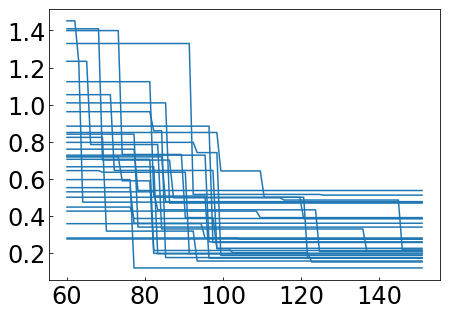

In [24]:
Obj_list = np.load('DiffStarPointTest_newGPT_150iter_30pts.npy')

fig = plt.figure(figsize = (7,5))
for i in range(len(Obj_list)):
    temp = -Obj_list[i,2::]
#     plt.plot(temp[2::], '-',c='C0')
    plt.plot(np.linspace(60,151,91),temp[60::],'-',c='C0')
    
# plt.yscale('log')
# plt.axhline(y = 0.039, c='red', linewidth = 2, label = 'grid search')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('GPy with new UCB parameter', fontsize=20)
plt.tick_params(direction='in')
plt.xlabel('Iteration #', fontsize = 20)
plt.ylabel('($\epsilon_\chi$), best seen', fontsize = 20)

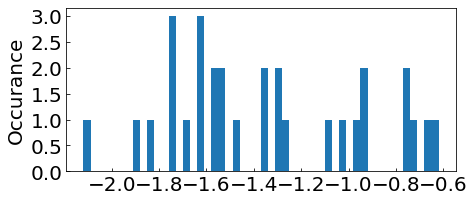

In [25]:
fig = plt.figure(figsize = (7,3))
_ = plt.hist(np.log(-np.asarray(Obj_list)[:,-1]), bins = 50)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.yticks(fontsize=20)
# plt.xticks([])
plt.xticks(fontsize=20)
plt.ylabel('Occurance', fontsize = 20)
plt.tick_params(direction='in')
plt.show()

## Run line scan for each of the parameter

200000.0 215862.06896551725 -8.96048411718694 -872.8255832750212


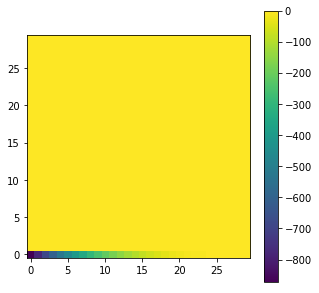

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [50]:
# 2D parameter scan for all (S1, S2) pairs
ndim = 8 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, 390000, -654100]]

S1_list = np.linspace(2.0e5,2.2e5,num=30)
S2_list = np.linspace(2.5e5, 2.7e5, num=30)
# emit_matrix = np.zeros([30, 30])
emit_matrix = np.load('S1_S2_2.0-2.2e5_2.5-2.7e5.npy')

for i in range(len(S1_list)):
    for j in range(len(S2_list)):
        
        if emit_matrix[i,j]!=0:
            continue
        start_point = [[890, 0, S1_list[i], S2_list[j], 119931.5, 648691.415, 390000, -654100]] 
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(S1_list[i], S2_list[j], emit_matrix[i,j], np.amin(emit_matrix[emit_matrix!=0]))
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('S1_S2_2.0-2.2e5_2.5-2.7e5.png')
        np.save('S1_S2_2.0-2.2e5_2.5-2.7e5.npy',emit_matrix)

-51.01776816563012


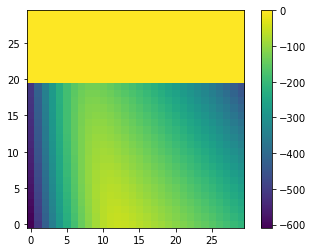

In [46]:
temp = np.load('S1_S2_0-500000.npy')
temp = np.load('S1_S2_2.2-2.4e5_2.5-2.7e5.npy')
temp = np.load('S3_S4_1.1e5-1.3e5_6.0-7.0e5.npy')
plt.imshow(temp, origin='lower')
plt.colorbar()
print(np.amax(temp[temp!=0]))

130000.0 700000.0 -95412.04449227193 -4531207.416809689


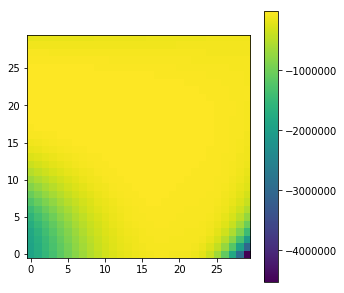

In [54]:
# 2D parameter scan for all (S3, S4) pairs
ndim = 8 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, 390000, -654100]]

S3_list = np.linspace(110000,130000,num=30)
S4_list = np.linspace(600000,700000, num=30)
# emit_matrix = np.zeros([30,30])
emit_matrix = np.load('S3_S4_1.1e5-1.3e5_6.0-7.0e5.npy')

for i in range(len(S3_list)):
    for j in range(len(S4_list)):
        if emit_matrix[i,j] != 0:
            continue
        start_point = [[890, 0, 2.5e5, 2.5e5, S3_list[i], S4_list[j], 390000, -654100]] 
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(S3_list[i], S4_list[j], emit_matrix[i,j], np.amin(emit_matrix[emit_matrix!=0]))
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('S3_S4_1.1-1.3e5_6.0-7.0e5.png')
        np.save('S3_S4_1.1e5-1.3e5_6.0-7.0e5.npy',emit_matrix)

400000.0 -650000.0 -459.81959195449355


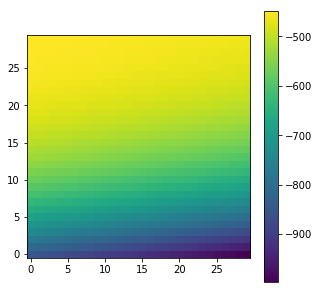

In [32]:
# 2D parameter scan for all (S6, S7) pairs
ndim = 8 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, 390000, -654100]]

S6_list = np.linspace(380000,400000,num=30)
S7_list = np.linspace(-660000,-650000, num=30)
emit_matrix = np.zeros([30, 30])

for i in range(len(S6_list)):
    for j in range(len(S7_list)):

        start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, S6_list[i], S7_list[j]]] 
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(S6_list[i], S7_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('S6_S7_new.png')
        np.save('S6_S7_new.npy',emit_matrix)

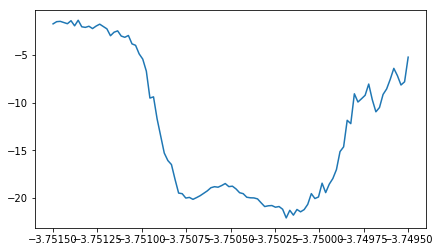

In [9]:
fig = plt.figure(figsize=[7,4])
emit_profile = np.load('OBJ_-3.7515e6_-3.7495e6_100steps_40mrad_CNNemittance.npy')
plt.plot(np.linspace(-3.7515e6,-3.7495e6,num=100)/1e6, emit_profile)

-3749500.0 [-3.20048237]


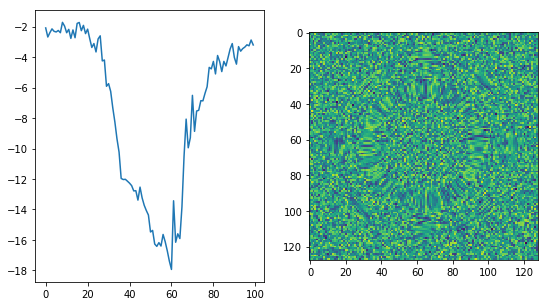

In [3]:
# Line scan for objective lens
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

OBJ_list = np.linspace(-3.7515e6,-3.7495e6,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(OBJ_list)):

    start_point = [[1498 , 0, 390000 , -654100, OBJ_list[i]]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(OBJ_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('OBJ_-3.7515e6_-3.7495e6_100steps_60mrad_CNNemittance.npy',emit_profile)

2000.0 [-14.0461092]


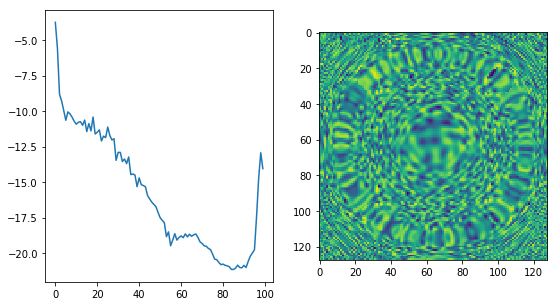

In [3]:
# Line scan for H1
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

H1_list = np.linspace(500,2000,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(H1_list)):

    start_point = [[H1_list[i] , 0, 390000 , -654100, -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(H1_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('H1_500_2000_100steps_CNNemittance.npy',emit_profile)

393000.0 [-1.29585838]


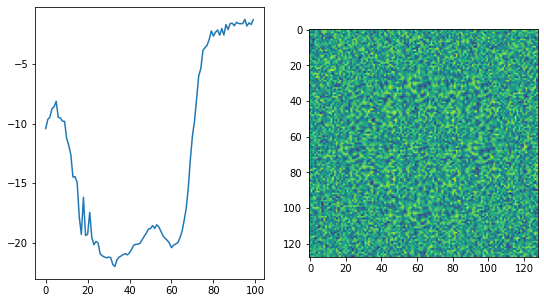

In [3]:
# Line scan for S6
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S6_list = np.linspace(387000,393000,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(S6_list)):

    start_point = [[1498.2, 0, S6_list[i], -654100, -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S6_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S6_3.87e5_3.93e5_100steps_40mrad_CNNemittance.npy',emit_profile)

-655151.5151515151 [-2.94958782]


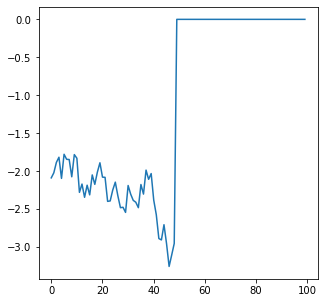

49
Model loaded


In [ ]:
# Line scan for S7
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S7_list = np.linspace(-660000,-650000, num=100)
emit_profile = np.zeros([100,1])

for i in range(len(S7_list)):
    print(i)
    start_point = [[1498.2, 0, 391515, S7_list[i], -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S7_list[i], emit_profile[i])
    fig = plt.figure(figsize = [5,5])
    plt.plot(emit_profile)
    plt.show()
    np.save('S7_-6.6e5_-6.5e5_100steps_40mrad_CNNemittance.npy',emit_profile)

20.0 [-20.32716179]


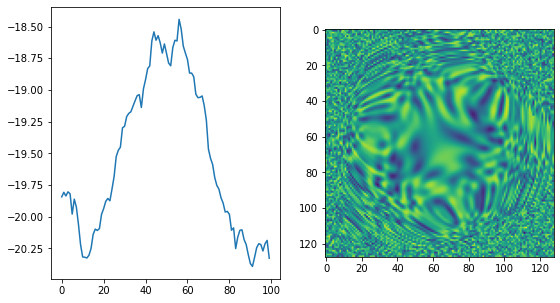

In [3]:
# Line scan for deltaH
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

deltaH_list = np.linspace(-20, 20, num=100)
emit_profile = np.zeros([100,1])
emit_profile = np.load('deltaH_-20_20_100steps_40mrad_CNNemittance.npy')

for i in range(len(deltaH_list)):
    
    if emit_profile[i]!=0:
        continue

    start_point = [[1498.2 , deltaH_list[i], 390000 , -654100, -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(deltaH_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('deltaH_-20_20_100steps_40mrad_CNNemittance.npy',emit_profile)

## Aux Functions

## Previously used scripts